**Title: Analyzing FIFA World Cup Performances and Ranking from 1930 to 2022**

**Objectives**
1. Building a model that predict match outcome
2. To analyze the relationship between expected goal and actual goals scored and determining if expected goals is a good predictive metric.
3. Investigating the influence of penalties on match outcome by comparing the wins or draws by penalty in home and away teams.
4. To determine which team manager (Home and Away manager) have most impact on the match outcome using win rate as performance metric.
5. To analyze how each fifa ranked team ranking and points have changed over time.
6. To investigate how teams from different associations are performing in terms of average points and rankings.
7. To analyze the attendance number across different world cup years to see if there's a trend in spectator interest
8. To determine the all time goal scorrer and if there's a pattern in the number of goals scored in each world cup.

In [1]:
#Importing Libraries
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:
#Reading csv file into a dataframe
df3 = pd.read_csv("world_cup.csv")
df2 = pd.read_csv("fifa_ranking_2022-10-06.csv")
df0 = pd.read_csv("matches_1930_2022.csv")

**Objective 1**

**Building a model that predict match outcome**

In [3]:
#Creating a copy of df0
df1 = df0.copy()
df1.head()

,home_team,away_team,home_score,home_xg,home_penalty,away_score,away_xg,away_penalty,home_manager,home_captain,...,home_penalty_shootout_miss_long,away_penalty_shootout_miss_long,home_red_card,away_red_card,home_yellow_red_card,away_yellow_red_card,home_yellow_card_long,away_yellow_card_long,home_substitute_in_long,away_substitute_in_long
0,Argentina,France,3,3.3,4.0,3,2.2,2.0,Lionel Scaloni,Lionel Messi,...,NaN,"['3|1:1|Kingsley Coman', '5|2:1|Aurélien Tchou...",NaN,NaN,NaN,NaN,"['45+7&rsquor;|2:0|Enzo Fernández', '90+8&rsqu...","['55&rsquor;|2:0|Adrien Rabiot', '87&rsquor;|2...",['64&rsquor;|2:0|Marcos Acuña|for Ángel Di Mar...,['41&rsquor;|2:0|Randal Kolo Muani|for Ousmane...
1,Croatia,Morocco,2,0.7,NaN,1,1.2,NaN,Zlatko Dalić,Luka Modrić,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['69&rsquor;|2:1|Azzedine Ounahi', '84&rsquor;...",['61&rsquor;|2:1|Nikola Vlašić|for Andrej Kram...,['46&rsquor;|2:1|Ilias Chair|for Abdelhamid Sa...
2,France,Morocco,2,2.0,NaN,0,0.9,NaN,Didier Deschamps,Hugo Lloris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['27&rsquor;|1:0|Sofiane Boufal'],['65&rsquor;|1:0|Marcus Thuram|for Olivier Gir...,['21&rsquor;|1:0|Selim Amallah|for Romain Saïs...
3,Argentina,Croatia,3,2.3,NaN,0,0.5,NaN,Lionel Scaloni,Lionel Messi,...,NaN,NaN,NaN,NaN,NaN,NaN,"['68&rsquor;|2:0|Cristian Romero', '71&rsquor;...","['32&rsquor;|0:0|Mateo Kovačić', '32&rsquor;|0...",['62&rsquor;|2:0|Lisandro Martínez|for Leandro...,"['46&rsquor;|2:0|Mislav Oršić|for Borna Sosa',..."
4,Morocco,Portugal,1,1.4,NaN,0,0.9,NaN,Hoalid Regragui,Romain Saïss,...,NaN,NaN,NaN,NaN,Walid Cheddira · 90+3,NaN,"['70&rsquor;|1:0|Achraf Dari', '90+1&rsquor;|1...",['87&rsquor;|1:0|Vitinha'],['57&rsquor;|1:0|Achraf Dari|for Romain Saïss'...,['51&rsquor;|1:0|João Cancelo|for Raphaël Guer...


In [4]:
#Setting  index for df1
df1 = df1.set_index(["Year", "Host", "Round"])
#Filling NaN in "home_penalty" and "away_penalty" column
df1["home_penalty"]= df1["home_penalty"].fillna(0).astype("int64")
df1["away_penalty"]= df1["away_penalty"].fillna(0).astype("int64")
df1["away_xg"] = df1["away_xg"].fillna(0)
df1["home_xg"] = df1["home_xg"].fillna(0)

In [5]:
#Creating match_outcome column for df1
def match_outcome(row):
    if row["home_score"] > row["away_score"]:
        return "Home Win"
    elif row["home_score"] < row["away_score"]:
        return "Away Win"
    else:
        return "Draw"
df1["match_outcome"] = df1.apply(match_outcome, axis = 1)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 964 entries, (2022, 'Qatar', 'Final') to (1930, 'Uruguay', 'Group stage')
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   home_team                        964 non-null    object 
 1   away_team                        964 non-null    object 
 2   home_score                       964 non-null    int64  
 3   home_xg                          964 non-null    float64
 4   home_penalty                     964 non-null    int64  
 5   away_score                       964 non-null    int64  
 6   away_xg                          964 non-null    float64
 7   away_penalty                     964 non-null    int64  
 8   home_manager                     964 non-null    object 
 9   home_captain                     644 non-null    object 
 10  away_manager                     964 non-null    object 
 11  away_captain                    

In [7]:
#Dropping un-needed columns
df1.drop(
    columns = [
        "Notes",
        "Date",
        "home_red_card",
        "away_red_card",
        "home_yellow_red_card",
        "away_yellow_red_card",
        "home_yellow_card_long",
        "away_yellow_card_long",
        "home_substitute_in_long",
        "away_substitute_in_long",
        "Referee",  
    ],inplace = True
)

In [8]:
#Filling NaN in df1 with the value "None"
df1 = df1.fillna("None")

In [9]:
#Transforming various columns 
label_encoder = LabelEncoder()
df1["home_team"] = label_encoder.fit_transform(df1["home_team"])
df1["away_team"] = label_encoder.fit_transform(df1["away_team"])
df1["home_manager"] = label_encoder.fit_transform(df1["home_manager"])
df1["away_manager"] = label_encoder.fit_transform(df1["away_manager"])
df1["away_penalty"] = label_encoder.fit_transform(df1["away_penalty"])
df1["home_penalty"] = label_encoder.fit_transform(df1["home_penalty"])

In [10]:
#Exploring df1 further
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 964 entries, (2022, 'Qatar', 'Final') to (1930, 'Uruguay', 'Group stage')
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   home_team                        964 non-null    int32  
 1   away_team                        964 non-null    int32  
 2   home_score                       964 non-null    int64  
 3   home_xg                          964 non-null    float64
 4   home_penalty                     964 non-null    int64  
 5   away_score                       964 non-null    int64  
 6   away_xg                          964 non-null    float64
 7   away_penalty                     964 non-null    int64  
 8   home_manager                     964 non-null    int32  
 9   home_captain                     964 non-null    object 
 10  away_manager                     964 non-null    int32  
 11  away_captain                    

home_team  away_team  home_score  home_xg  \
Year Host  Round                                                          
2022 Qatar Final                      2         28           3      3.3   
           Third-place match         16         47           2      0.7   
           Semi-finals               26         47           2      2.0   
           Semi-finals                2         16           3      2.3   
           Quarter-finals            43         57           1      1.4   

                              home_penalty  away_score  away_xg  away_penalty  \
Year Host  Round                                                                
2022 Qatar Final                         4           3      2.2             2   
           Third-place match             0           1      1.2             0   
           Semi-finals                   0           0      0.9             0   
           Semi-finals                   0           0      0.5             0   
           Quarter-finals                0           0      0.9             0   

                              home_manager  home_captain  ...  away_own_goal  \
Year Host  Round                                          ...                  
2022 Qatar Final                       189  Lionel Messi  ...           None   
           Third-place match           324   Luka Modrić  ...           None   
           Semi-finals                  66   Hugo Lloris  ...           None   
           Semi-finals                 189  Lionel Messi  ...           None   
           Quarter-finals              123  Romain Saïss  ...           None   

                                  home_penalty_goal  \
Year Host  Round                                      
2022 Qatar Final              Lionel Messi (P) · 23   
           Third-place match                   None   
           Semi-finals                         None   
           Semi-finals        Lionel Messi (P) · 34   
           Quarter-finals                      None   

                                                           away_penalty_goal  \
Year Host  Round                                                               
2022 Qatar Final              Kylian Mbappé (P) · 80|Kylian Mbappé (P) · 118   
           Third-place match                                            None   
           Semi-finals                                                  None   
           Semi-finals                                                  None   
           Quarter-finals                                               None   

                             home_penalty_miss_long away_penalty_miss_long  \
Year Host  Round                                                             
2022 Qatar Final                               None                   None   
           Third-place match                   None                   None   
           Semi-finals                         None                   None   
           Semi-finals                         None                   None   
           Quarter-finals                      None                   None   

                                                home_penalty_shootout_goal_long  \
Year Host  Round                                                                  
2022 Qatar Final              ['2|1:1|Lionel Messi', '4|2:1|Paulo Dybala', '...   
           Third-place match                                               None   
           Semi-finals                                                     None   
           Semi-finals                                                     None   
           Quarter-finals                                                  None   

                                                away_penalty_shootout_goal_long  \
Year Host  Round                                                                  
2022 Qatar Final              ['1|0:1|Kylian Mbappé', '7|3:2|Randal Kolo Mua...   
           Third-place match                      

In [11]:
df1["away_penalty_goal"].nunique()

85

In [12]:
#Setting my feature matrix and target vector
target = "match_outcome"
X = df1[["home_team","away_team","home_xg","home_penalty","away_xg","away_penalty","home_score","away_score"]]
y = df1[target]
print("X Shape:", X.shape)
print("y Shape:",y.shape)

X Shape: (964, 8)
y Shape: (964,)


In [13]:
#Spliting my data into training and test set using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2,random_state=42
)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (771, 8)
y_train Shape: (771,)
X_test Shape: (193, 8)
y_test Shape: (193,)


In [14]:
#Calculating the baseline accuracy score for my model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline,4))

Baseline Accuracy: 0.5668


In [15]:
#Defining my model
clf = RandomForestClassifier()

In [16]:
#Calculating cross validation score
cv_acc_scores = cross_val_score(clf, X_train, y_train, cv =5, n_jobs =-1)
print(cv_acc_scores)

[0.99354839 0.98701299 1.         0.99350649 0.99350649]


In [17]:
#Hyperparameter Grid
params = {
    "n_estimators":range(50,100),
    "max_depth":range(4,6,8),
    "min_samples_split":[2,5],
    "min_samples_leaf":[1,2],
    "max_features":["sqrt", "log2"]
}
params

{'n_estimators': range(50, 100),
 'max_depth': range(4, 6, 8),
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2],
 'max_features': ['sqrt', 'log2']}

In [18]:
#Creating a GridSearchCV which includes my classifier and hyperparameter grid
model = GridSearchCV(
    clf,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(4, 6, 8),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': range(50, 100)},
             verbose=1)

In [19]:
#Standardizing features to improve my model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [20]:
#fitting model to find the best parameters
model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(4, 6, 8),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': range(50, 100)},
             verbose=1)

In [21]:
#Best model after grid search
best_model = model.best_estimator_
print("Best Parameters:", model.best_params_)

Best Parameters: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 63}


In [22]:
#Using my best model to make predictions
best_model.predict(X_test_scaled)

array(['Home Win', 'Home Win', 'Home Win', 'Home Win', 'Home Win',
       'Away Win', 'Away Win', 'Draw', 'Draw', 'Home Win', 'Home Win',
       'Home Win', 'Draw', 'Home Win', 'Home Win', 'Draw', 'Away Win',
       'Away Win', 'Home Win', 'Home Win', 'Home Win', 'Home Win',
       'Home Win', 'Away Win', 'Home Win', 'Home Win', 'Away Win',
       'Away Win', 'Home Win', 'Away Win', 'Away Win', 'Away Win',
       'Home Win', 'Away Win', 'Home Win', 'Home Win', 'Home Win',
       'Home Win', 'Away Win', 'Away Win', 'Draw', 'Home Win', 'Home Win',
       'Draw', 'Away Win', 'Home Win', 'Home Win', 'Home Win', 'Home Win',
       'Away Win', 'Home Win', 'Home Win', 'Home Win', 'Away Win', 'Draw',
       'Away Win', 'Home Win', 'Home Win', 'Away Win', 'Draw', 'Home Win',
       'Home Win', 'Home Win', 'Home Win', 'Away Win', 'Home Win',
       'Away Win', 'Draw', 'Home Win', 'Home Win', 'Away Win', 'Home Win',
       'Home Win', 'Home Win', 'Draw', 'Home Win', 'Away Win', 'Home Win',
      

In [23]:
#Calculating the training and test accuracy of my model
acc_train = best_model.score(X_train_scaled, y_train)
acc_test = best_model.score(X_test_scaled, y_test)
print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9248
Test Accuracy: 0.8756


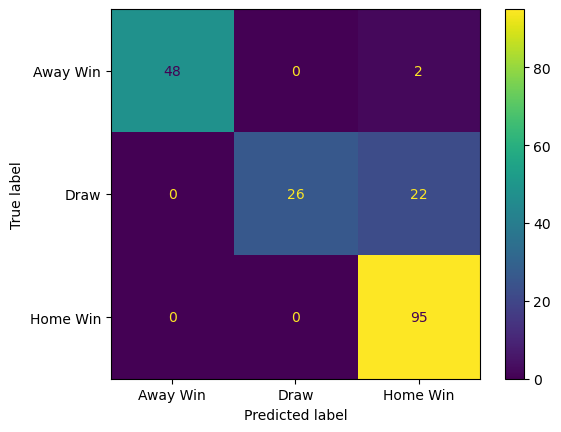

In [24]:
#Plotting a confusion matrix that shows how my model perform on my test set
ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test);

**Interpretation of Result**

**From the confusion matrix above, The diagonal represent the number of correctly predicted instances for each
class. where as every non-zero vaues outside the diagonal represent missclassification , where the model's prediction does'nt match the actual label and zero vaues outside the diagonal indicates that the model perfectly
predicted the classes for that set of data.**


**Objective 2**

**To analyze the relationship between expected goal and actual goals scored and determining if expected goals is a good predictive metric.**

In [25]:
#Checking the correlation between "home_xg" and "home_score"
home_corr = df1["home_xg"].corr(df1["home_score"]).round(2)
print("Correlation Home Team xG vs Actual Goals:", home_corr)

Correlation Home Team xG vs Actual Goals: 0.05


In [26]:
#Checking the correlation between "away_xg" and "away_score"
away_corr = df1["away_xg"].corr(df1["away_score"]).round(2)
print("Correlation Away Team xG vs Actual Goals:", away_corr)

Correlation Away Team xG vs Actual Goals: 0.13


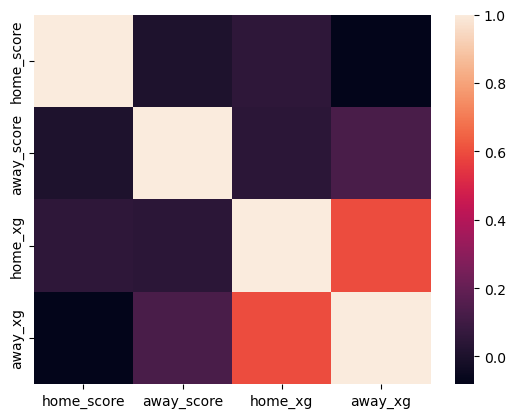

In [27]:
#Plotting a correlation heatmap to visualize how my features correlate
corr = df1[["home_score","away_score","home_xg","away_xg"]].corr()
sns.heatmap(corr);

**Interpretation of Results 1**

**From the heatmap above, it can be seen that there is correlation between the features. when it comes to home_score (home goal) and home_xg (expected goal) it can be seen that there is a very weak positve correlation of "0.05" where as, when it comes to away_score (away goal) and away_xg (expected goal) there is a weak positive correlation of "0.13".**
**So it can be said that there is a relationship between expected goal and actual goals scored.**

In [28]:
#Calculating home baseline predictions
home_mean_goal_pred = df1["home_score"].mean()
home_baseline_predictions = [home_mean_goal_pred]*len(df1)
home_baseline_mae = mean_absolute_error(df1["home_score"], home_baseline_predictions).round(4)
#Calculating away baseline predictions
away_mean_goal_pred = df1["away_score"].mean()
away_baseline_predictions = [away_mean_goal_pred]*len(df1)
away_baseline_mae = mean_absolute_error(df1["home_score"], away_baseline_predictions).round(4)
#Calculating  xG vs Actual
home_mae = mean_absolute_error(df1["home_score"], df1["home_xg"]).round(4)
away_mae = mean_absolute_error(df1["away_score"], df1["away_xg"]).round(4)
#Printing results
print("Home Baseline MAE:", home_baseline_mae)
print("Away Baseline MAE:", away_baseline_mae)
print("MAE Home Team xG vs Actual Goals:", home_mae)
print("MAE Away Team xG vs Actual Goals:", away_mae)

Home Baseline MAE: 1.2198
Away Baseline MAE: 1.2092
MAE Home Team xG vs Actual Goals: 1.6917
MAE Away Team xG vs Actual Goals: 0.9838


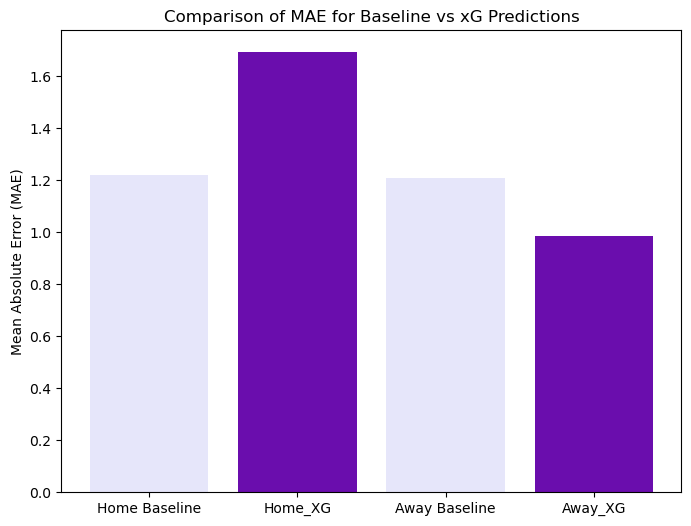

In [29]:
#Plot of baseline MAE vs xG Predictions
mae_values = [home_baseline_mae,home_mae,away_baseline_mae,away_mae]
labels = ["Home Baseline","Home_XG","Away Baseline","Away_XG"]
plt.figure(figsize = (8,6))
plt.bar(labels, mae_values, color = ["#E6E6FA","#6A0DAD","#E6E6FA","#6A0DAD"])
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of MAE for Baseline vs xG Predictions");

**Interpretation of Result 2**

**Looking at the result above when it comes to Home, having a baseline MAE(mean absolute error) of approximately "1.2" which is lower than XG-based prediction of approximately "1.7" suggests that the metric XG may not be as effective for predicting home team goals as using the average.
On the other hand, when it comes to away, the away baseline MAE of approximately "1.2" which is higher that the XG-based prediction MAE approximately "1" suggests that the XG metric is a better predictor for away team goals compared to the baseline**

**Objective 3**

**Investigating the influence of penalties on match outcome by comparing the wins or draws by penalty in home and away teams**

In [30]:
#Creating match_outcome column for df0
def match_outcome(row):
    if row["home_score"] > row["away_score"]:
        return "Home Win"
    elif row["home_score"] < row["away_score"]:
        return "Away Win"
    else:
        return "Draw"
df0["match_outcome"] = df0.apply(match_outcome, axis = 1)

In [31]:
#Dropping un-needed columns and setting index
df0_subset = df0[
[
    "home_team",
    "away_team",
    "home_score",
    "away_score",
    "home_penalty_goal",
    "away_penalty_goal",
    "Score",
    "match_outcome",
    "Year"
]].set_index(keys = "Year")

In [32]:
#Subsetting dataset
df0_subset_away = df0_subset[df0_subset["away_penalty_goal"].notna()].drop(columns ="home_penalty_goal")
df0_subset_home = df0_subset[df0_subset["home_penalty_goal"].notna()].drop(columns = "away_penalty_goal")

In [33]:
df0_subset_away.head()

,home_team,away_team,home_score,away_score,away_penalty_goal,Score,match_outcome
Year,,,,,,,
2022,Argentina,France,3,3,Kylian Mbappé (P) · 80|Kylian Mbappé (P) · 118,(4) 3–3 (2),Draw
2022,Netherlands,Argentina,2,2,Lionel Messi (P) · 73,(3) 2–2 (4),Draw
2022,France,Poland,3,1,Robert Lewandowski (P) · 90+9,3–1,Home Win
2022,Ecuador,Senegal,1,2,Ismaila Sarr (P) · 44,1–2,Away Win
2022,England,IR Iran,6,2,Mehdi Taremi (P) · 90+13,6–2,Home Win


In [34]:
#Subsetting dataset
mask_penalty_away_win = df0_subset_away["away_penalty_goal"].notna()
mask_outcome_away_win = df0_subset_away["match_outcome"] == "Away Win"
df0_subset_away_win = df0_subset_away[mask_penalty_away_win & mask_outcome_away_win]
df0_subset_away_win.head()

,home_team,away_team,home_score,away_score,away_penalty_goal,Score,match_outcome
Year,,,,,,,
2022,Ecuador,Senegal,1,2,Ismaila Sarr (P) · 44,1–2,Away Win
2022,Qatar,Ecuador,0,2,Enner Valencia (P) · 16,0–2,Away Win
2018,Mexico,Sweden,0,3,Andreas Granqvist (P) · 62,0–3,Away Win
2018,Korea Republic,Mexico,1,2,Carlos Vela (P) · 26,1–2,Away Win
2018,Colombia,Japan,1,2,Shinji Kagawa (P) · 6,1–2,Away Win


In [35]:
df0_subset_away_win["match_outcome"].nunique()

1

In [36]:
#Subsetting dataset
mask_penalty_away_draw = df0_subset_away["away_penalty_goal"].notna()
mask_outcome_away_draw = df0_subset_away["match_outcome"] == "Draw"
df0_subset_away_draw = df0_subset_away[mask_penalty_away_draw & mask_outcome_away_draw]
df0_subset_away_draw.head()

,home_team,away_team,home_score,away_score,away_penalty_goal,Score,match_outcome
Year,,,,,,,
2022,Argentina,France,3,3,Kylian Mbappé (P) · 80|Kylian Mbappé (P) · 118,(4) 3–3 (2),Draw
2022,Netherlands,Argentina,2,2,Lionel Messi (P) · 73,(3) 2–2 (4),Draw
2022,United States,Wales,1,1,Gareth Bale (P) · 82,1–1,Draw
2018,Colombia,England,1,1,Harry Kane (P) · 57,(3) 1–1 (4),Draw
2018,Spain,Russia,1,1,Artem Dzyuba (P) · 42,(3) 1–1 (4),Draw


In [37]:
df0_subset_away_draw["match_outcome"].nunique()

1

In [38]:
#Subsetting dataset
mask_penalty_home_win = df0_subset_home["home_penalty_goal"].notna()
mask_outcome_home_win = df0_subset_home["match_outcome"] == "Home Win"
df0_subset_home_win = df0_subset_home[mask_penalty_home_win & mask_outcome_home_win]
df0_subset_home_win.head()

,home_team,away_team,home_score,away_score,home_penalty_goal,Score,match_outcome
Year,,,,,,,
2022,Argentina,Croatia,3,0,Lionel Messi (P) · 34,3–0,Home Win
2022,Brazil,Korea Republic,4,1,Neymar (P) · 11,4–1,Home Win
2022,Portugal,Uruguay,2,0,Bruno Fernandes (P) · 90+3,2–0,Home Win
2022,Portugal,Ghana,3,2,Cristiano Ronaldo (P) · 65,3–2,Home Win
2022,Spain,Costa Rica,7,0,Ferrán Torres (P) · 31,7–0,Home Win


In [39]:
df0_subset_home_win["match_outcome"].nunique()

1

In [40]:
#Subsetting dataset
mask_penalty_home_draw = df0_subset_home["home_penalty_goal"].notna()
mask_outcome_home_draw = df0_subset_home["match_outcome"] == "Draw"
df0_subset_home_draw = df0_subset_home[mask_penalty_home_draw & mask_outcome_home_draw]
df0_subset_home_draw.head()

,home_team,away_team,home_score,away_score,home_penalty_goal,Score,match_outcome
Year,,,,,,,
2022,Argentina,France,3,3,Lionel Messi (P) · 23,(4) 3–3 (2),Draw
2018,IR Iran,Portugal,1,1,Karim Ansarifard (P) · 90+3,1–1,Draw
2018,Portugal,Spain,3,3,Cristiano Ronaldo (P) · 4,3–3,Draw
2010,Nigeria,Korea Republic,2,2,Yakubu Aiyegbeni (P) · 69,2–2,Draw
2010,Italy,New Zealand,1,1,Vincenzo Iaquinta (P) · 29,1–1,Draw


In [41]:
df0_subset_home_draw["match_outcome"].nunique()

1

In [42]:
#Counting the amount of wins and draws of home and away by penalty
away_win = df0_subset_away_win["match_outcome"].value_counts().sum()
away_draw = df0_subset_away_draw["match_outcome"].value_counts().sum()
home_win = df0_subset_home_win["match_outcome"].value_counts().sum()
home_draw = df0_subset_home_draw["match_outcome"].value_counts().sum()

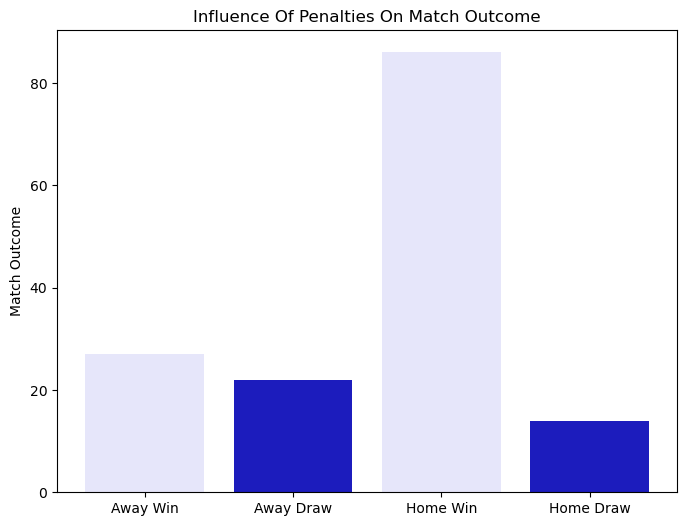

In [43]:
#Plotting home and away draws and wins by penalty
match_outcome = [away_win,away_draw,home_win,home_draw]
labels = ["Away Win","Away Draw","Home Win","Home Draw"]
plt.figure(figsize = (8,6))
plt.bar(labels, match_outcome, color = ["#E6E6FA","#1c1cbd","#E6E6FA","#1c1cbd"])
plt.ylabel("Match Outcome")
plt.title("Influence Of Penalties On Match Outcome");

**Interpretation of Result**

**From the plot above, comparing away win to home win and away draw to home draw it can be seen that when it comes
to win or draw by penalty, teams at home tends to do win more and draw less matches unlike away teams where the 
margin between wins and draws is'nt all that significant.**

**Objective 4**

**To determine which team manager (Home and Away manager) have most impact on the match outcome using win rate as performance metric.**

In [44]:
# Selecting needed columns and setting index
df0_manager = df0[
[
    "home_team",
    "away_team",
    "home_manager",
    "away_manager",
    "match_outcome",
    "Year"
]].set_index("Year")
df0_manager.head()

,home_team,away_team,home_manager,away_manager,match_outcome
Year,,,,,
2022,Argentina,France,Lionel Scaloni,Didier Deschamps,Draw
2022,Croatia,Morocco,Zlatko Dalić,Hoalid Regragui,Home Win
2022,France,Morocco,Didier Deschamps,Hoalid Regragui,Home Win
2022,Argentina,Croatia,Lionel Scaloni,Zlatko Dalić,Home Win
2022,Morocco,Portugal,Hoalid Regragui,Fernando Santos,Home Win


In [45]:
#Subsetting dataset
df0_away_manager = df0_manager.drop(
    columns = [
        "home_manager",
        "home_team"
    ]
).set_index(["away_manager", "away_team"])
df0_away_manager_mask = df0_away_manager["match_outcome"] == "Away Win"
df0_away_manager = df0_away_manager[df0_away_manager_mask]
df0_away_manager = df0_away_manager.sort_index(level = ["away_manager"],ascending = False)

In [46]:
#Creating match_won coulmn
def match_outcome(row):
    if row["match_outcome"] == "Away Win":
        return "1"
    else: 
        return 0
df0_away_manager["matches_won"] = df0_away_manager.apply(match_outcome, axis = 1).astype("int64")
df0_away_manager

match_outcome  matches_won
away_manager        away_team                            
Şenol Güneş         Türkiye         Away Win            1
                    Türkiye         Away Win            1
                    Türkiye         Away Win            1
Óscar Tabárez       Uruguay         Away Win            1
                    Uruguay         Away Win            1
...                                      ...          ...
Alexandre Guimarães Costa Rica      Away Win            1
Alejandro Sabella   Argentina       Away Win            1
Akira Nishino       Japan           Away Win            1
Aimé Jacquet        France          Away Win            1
Adam Nawałka        Poland          Away Win            1

[218 rows x 2 columns]

In [47]:
#Subsetting dataset
df0_home_manager = df0_manager.drop(
    columns = [
        "away_manager",
        "away_team"
    ]
).set_index(["home_manager", "home_team"])
df0_home_manager_mask = df0_home_manager["match_outcome"] == "Home Win"
df0_home_manager = df0_home_manager[df0_home_manager_mask]
df0_home_manager = df0_home_manager.sort_index(level = ["home_manager"],ascending = False)

In [48]:
#Creating match_won coulmn
def match_outcome(row):
    if row["match_outcome"] == "Home Win":
        return "1"
    else: 
        return 0
df0_home_manager["matches_won"] = df0_home_manager.apply(match_outcome, axis = 1).astype("int64")
df0_home_manager

match_outcome  matches_won
home_manager       home_team                           
Şenol Güneş        Türkiye        Home Win            1
Óscar Tabárez      Uruguay        Home Win            1
                   Uruguay        Home Win            1
                   Uruguay        Home Win            1
                   Uruguay        Home Win            1
...                                    ...          ...
Aimé Jacquet       France         Home Win            1
Ademar Pimenta     Brazil         Home Win            1
                   Brazil         Home Win            1
                   Brazil         Home Win            1
Abdelmajid Chetali Tunisia        Home Win            1

[532 rows x 2 columns]

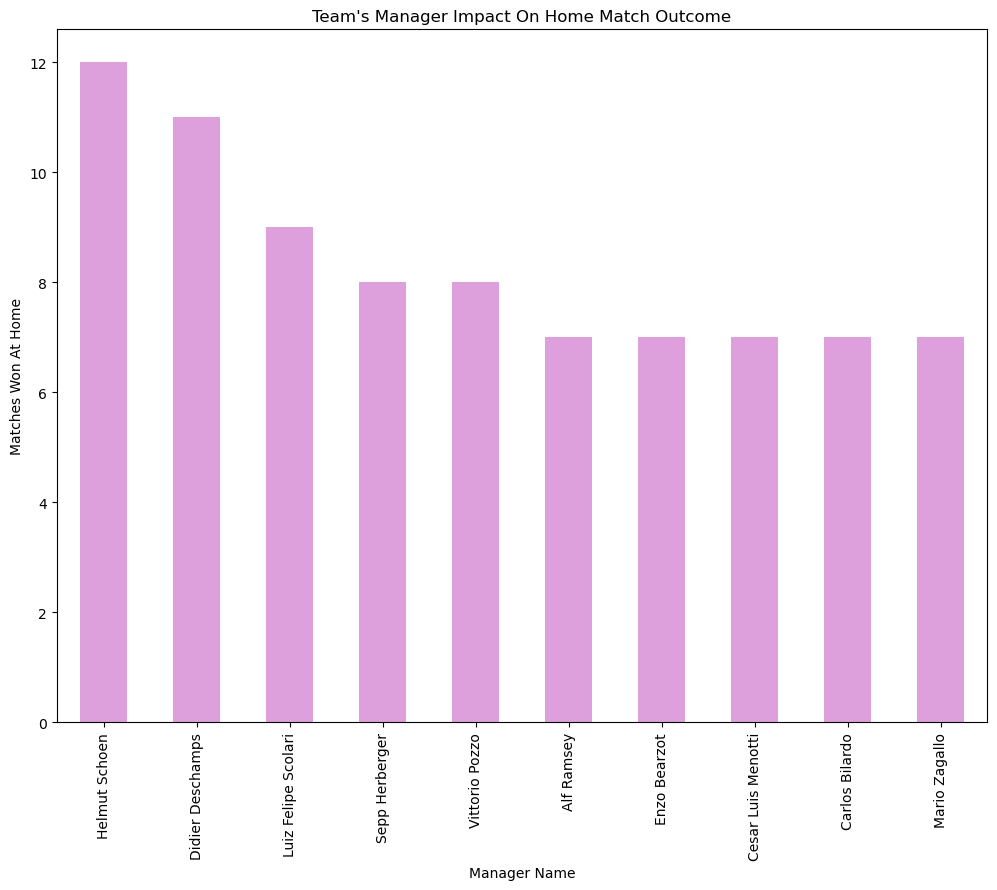

In [49]:
#Plotting Team managers impact on home outcome
plt.figure(figsize=(12,9))
(
    df0_home_manager
    .groupby("home_manager")
    ["matches_won"].sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(
        kind = "bar",
        xlabel = "Manager Name",
        ylabel = "Matches Won At Home",
        title = "Team's Manager Impact On Home Match Outcome",
        color = "plum"
    )
);

**Interpretation of Result 1**

**From the diagram above looking at Home teams it can be seen that manager "Helmut Schoen" have the most 
impact on the match outcome**

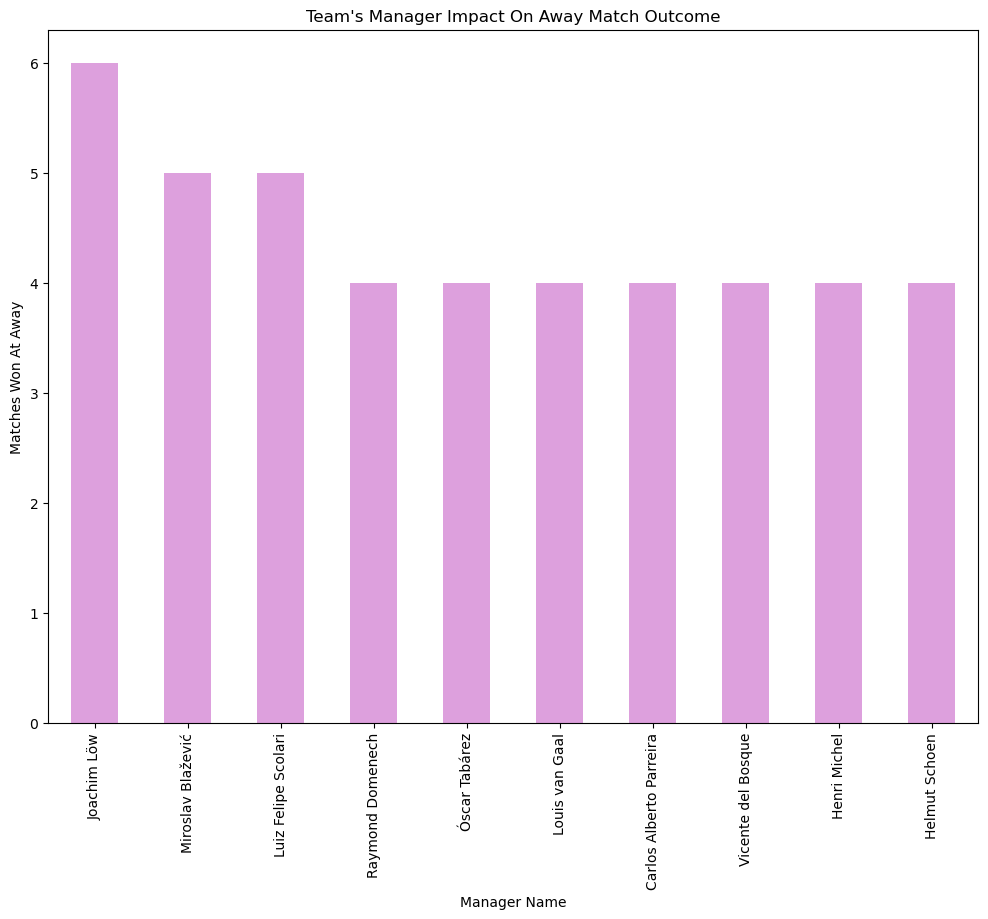

In [50]:
#Plotting Team managers impact on away outcome
plt.figure(figsize=(12,9))
(
    df0_away_manager
    .groupby("away_manager")
    ["matches_won"].sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(
        kind = "bar",
        xlabel = "Manager Name",
        ylabel = "Matches Won At Away",
        title = "Team's Manager Impact On Away Match Outcome",
        color = "plum"
    )
);

**Interpretation of Result 2**

**From the diagram above looking at Away teams it can be seen that manager "Joachim Low" have the most 
impact on the match outcome**

**Objective 5**

**To analyze how each fifa ranked team ranking and points have changed over time.**

In [51]:
#Creating new columns
df2["change_in_points"] = df2["points"] - df2["previous_points"]
df2["change_in_rank"] = df2["previous_rank"] - df2["rank"]
#Creating df2_fifa_change dataset
mask_change_in_point1 = df2["change_in_points"] < 0
mask_change_in_point2 = df2["change_in_points"] > 0
df2_fifa_change = df2[mask_change_in_point1 | mask_change_in_point2]
df2_fifa_change = df2_fifa_change.sort_values(by="change_in_points", ascending = True)
df2_fifa_change = df2_fifa_change.set_index("team")
df2_fifa_change.head(10)

,team_code,association,rank,previous_rank,points,previous_points,change_in_points,change_in_rank
team,,,,,,,,
North Macedonia,MKD,UEFA,65,64,1358.51,1375.20,-16.69,-1
Norway,NOR,UEFA,42,36,1473.04,1488.57,-15.53,-6
Türkiye,TUR,UEFA,45,42,1460.14,1475.13,-14.99,-3
Curaçao,CUW,CONCACAF,86,84,1278.64,1293.35,-14.71,-2
Slovakia,SVK,UEFA,55,51,1425.59,1439.99,-14.40,-4
Montenegro,MNE,UEFA,69,67,1341.03,1354.59,-13.56,-2
Cameroon,CMR,CAF,43,38,1471.44,1484.95,-13.51,-5
Wales,WAL,UEFA,19,19,1569.82,1582.13,-12.31,0
Liechtenstein,LIE,UEFA,196,194,862.39,873.99,-11.60,-2


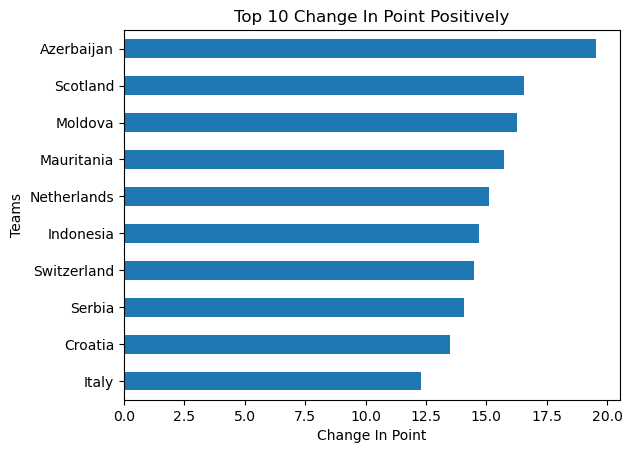

In [52]:
#Plotting the top 10 change in points positively
diff_in_points = df2_fifa_change["change_in_points"]
diff_in_points.tail(10).plot(kind="barh")
plt.xlabel("Change In Point")
plt.ylabel("Teams")
plt.title("Top 10 Change In Point Positively");

**Interpretation of Results 1**

**From the diagram above when it comes to teams that had a change in point positively, Azerbaijan stands out
with "19.55" increase in points**

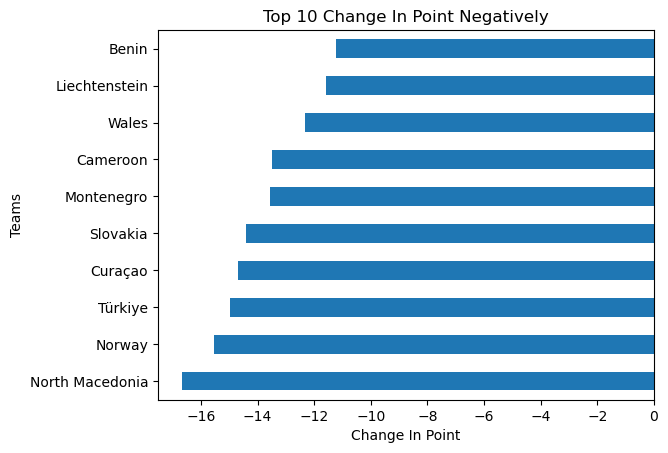

In [53]:
#Plotting the top 10 change in points negatively
diff_in_points = df2_fifa_change["change_in_points"]
diff_in_points.head(10).plot(kind="barh")
plt.xlabel("Change In Point")
plt.ylabel("Teams")
plt.title("Top 10 Change In Point Negatively");

**Interpretation of Results 2**

**On the other hand, North Macedonia had a decrease in points of about "-16.69" making them Top of
the negative change in point group**

In [54]:
#Creating new columns
mask_change_in_rank1 = df2["change_in_rank"] < 0
mask_change_in_rank2 = df2["change_in_rank"] > 0
#Creating df2_fifa_rank dataset
df2_fifa_rank = df2[mask_change_in_rank1 | mask_change_in_rank2]
df2_fifa_rank = df2_fifa_rank.sort_values(by="change_in_rank", ascending = True)
df2_fifa_rank = df2_fifa_rank.set_index("team")

In [55]:
df2_fifa_rank.head()

,team_code,association,rank,previous_rank,points,previous_points,change_in_points,change_in_rank
team,,,,,,,,
Norway,NOR,UEFA,42,36,1473.04,1488.57,-15.53,-6
Latvia,LVA,UEFA,134,129,1114.21,1125.36,-11.15,-5
Cameroon,CMR,CAF,43,38,1471.44,1484.95,-13.51,-5
Sweden,SWE,UEFA,25,20,1553.33,1563.44,-10.11,-5
Gibraltar,GIB,UEFA,204,200,852.16,856.55,-4.39,-4


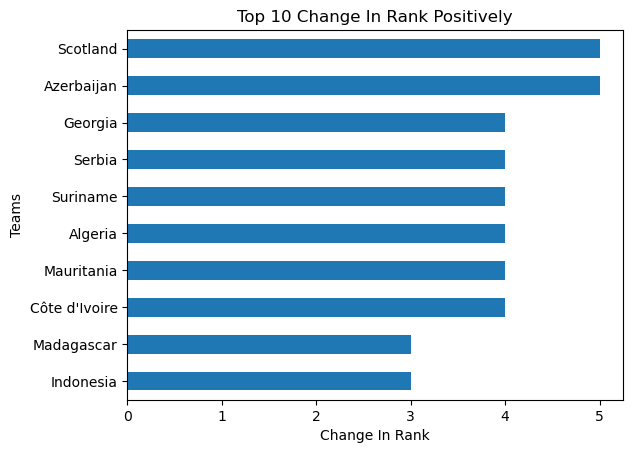

In [56]:
#Plotting the top 10 change in rank positively
diff_in_rank= df2_fifa_rank["change_in_rank"]
diff_in_rank.tail(10).plot(kind="barh")
plt.xlabel("Change In Rank")
plt.ylabel("Teams")
plt.title("Top 10 Change In Rank Positively");

**Interpretation of Result 3**

**When it comes to teams that went up in rank we have scotland and Azerbaijan both having a 
change in rank by "5"**

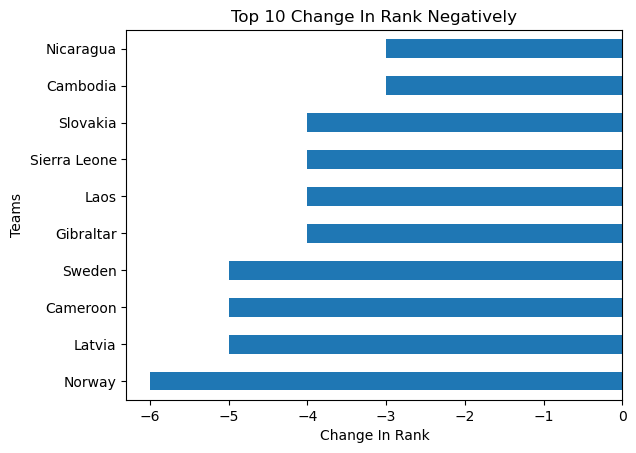

In [57]:
#Plotting the top 10 change in rank negatively
diff_in_rank= df2_fifa_rank["change_in_rank"]
diff_in_rank.head(10).plot(kind="barh")
plt.xlabel("Change In Rank")
plt.ylabel("Teams")
plt.title("Top 10 Change In Rank Negatively");

**Interpretation of Result 4**

**While on the other hand, Norway ("-6") had the lead when it comes to teams that had a decrease in rank**

**Objective 6**

**To investigate how teams from different associations are performing in terms of average points and rankings.**

In [58]:
#Creating a copy of df2 and setting index
df2_asson_per = df2.copy()
df2_asson_per = df2_asson_per.set_index(["association"]).sort_index()
df2_asson_per.head()

,team,team_code,rank,previous_rank,points,previous_points,change_in_points,change_in_rank
association,,,,,,,,
AFC,India,IND,106,104,1192.09,1198.65,-6.56,-2
AFC,Cambodia,CAM,177,174,948.62,954.30,-5.68,-3
AFC,Nepal,NEP,175,176,954.86,950.45,4.41,1
AFC,Qatar,QAT,50,48,1439.89,1441.97,-2.08,-2
AFC,Saudi Arabia,KSA,51,53,1437.78,1435.74,2.04,2


In [59]:
df2_asson_per.index.unique().tolist()

['AFC', 'CAF', 'CONCACAF', 'CONMEBOL', 'OFC', 'UEFA']

In [60]:
#Creating subset for each associations
df2_asson_per_0 = df2_asson_per.index == "AFC"
df2_asson_per_afc = df2_asson_per[df2_asson_per_0]
df2_asson_per_1 = df2_asson_per.index == "CAF"
df2_asson_per_caf = df2_asson_per[df2_asson_per_1]
df2_asson_per_2 = df2_asson_per.index == "CONCACAF"
df2_asson_per_concacaf = df2_asson_per[df2_asson_per_2]
df2_asson_per_3 = df2_asson_per.index == "CONMEBOL"
df2_asson_per_conmebol = df2_asson_per[df2_asson_per_3]
df2_asson_per_4 = df2_asson_per.index == "OFC"
df2_asson_per_ofc = df2_asson_per[df2_asson_per_4]
df2_asson_per_5 = df2_asson_per.index == "UEFA"
df2_asson_per_uefa = df2_asson_per[df2_asson_per_5]

In [61]:
#Ranking teams in each association based on their present rank
df2_asson_per_afc = df2_asson_per_afc.copy()
df2_asson_per_afc["rank"] = df2_asson_per_afc["rank"].rank(ascending = True)
df2_asson_per_afc = df2_asson_per_afc.sort_values(by = "rank", ascending = True)

df2_asson_per_caf = df2_asson_per_caf.copy()
df2_asson_per_caf["rank"] = df2_asson_per_caf["rank"].rank(ascending = True)
df2_asson_per_caf = df2_asson_per_caf.sort_values(by = "rank", ascending = True)

df2_asson_per_concacaf = df2_asson_per_concacaf.copy()
df2_asson_per_concacaf["rank"] = df2_asson_per_concacaf["rank"].rank(ascending = True)
df2_asson_per_concacaf = df2_asson_per_concacaf.sort_values(by = "rank", ascending = True)

df2_asson_per_conmebol = df2_asson_per_conmebol.copy()
df2_asson_per_conmebol["rank"] = df2_asson_per_conmebol["rank"].rank(ascending = True)
df2_asson_per_conmebol = df2_asson_per_conmebol.sort_values(by = "rank", ascending = True)

df2_asson_per_ofc = df2_asson_per_ofc.copy()
df2_asson_per_ofc["rank"] = df2_asson_per_ofc["rank"].rank(ascending = True)
df2_asson_per_ofc = df2_asson_per_ofc.sort_values(by = "rank", ascending = True)

df2_asson_per_uefa = df2_asson_per_uefa.copy()
df2_asson_per_uefa["rank"] = df2_asson_per_uefa["rank"].rank(ascending = True)
df2_asson_per_uefa = df2_asson_per_uefa.sort_values(by = "rank", ascending = True)

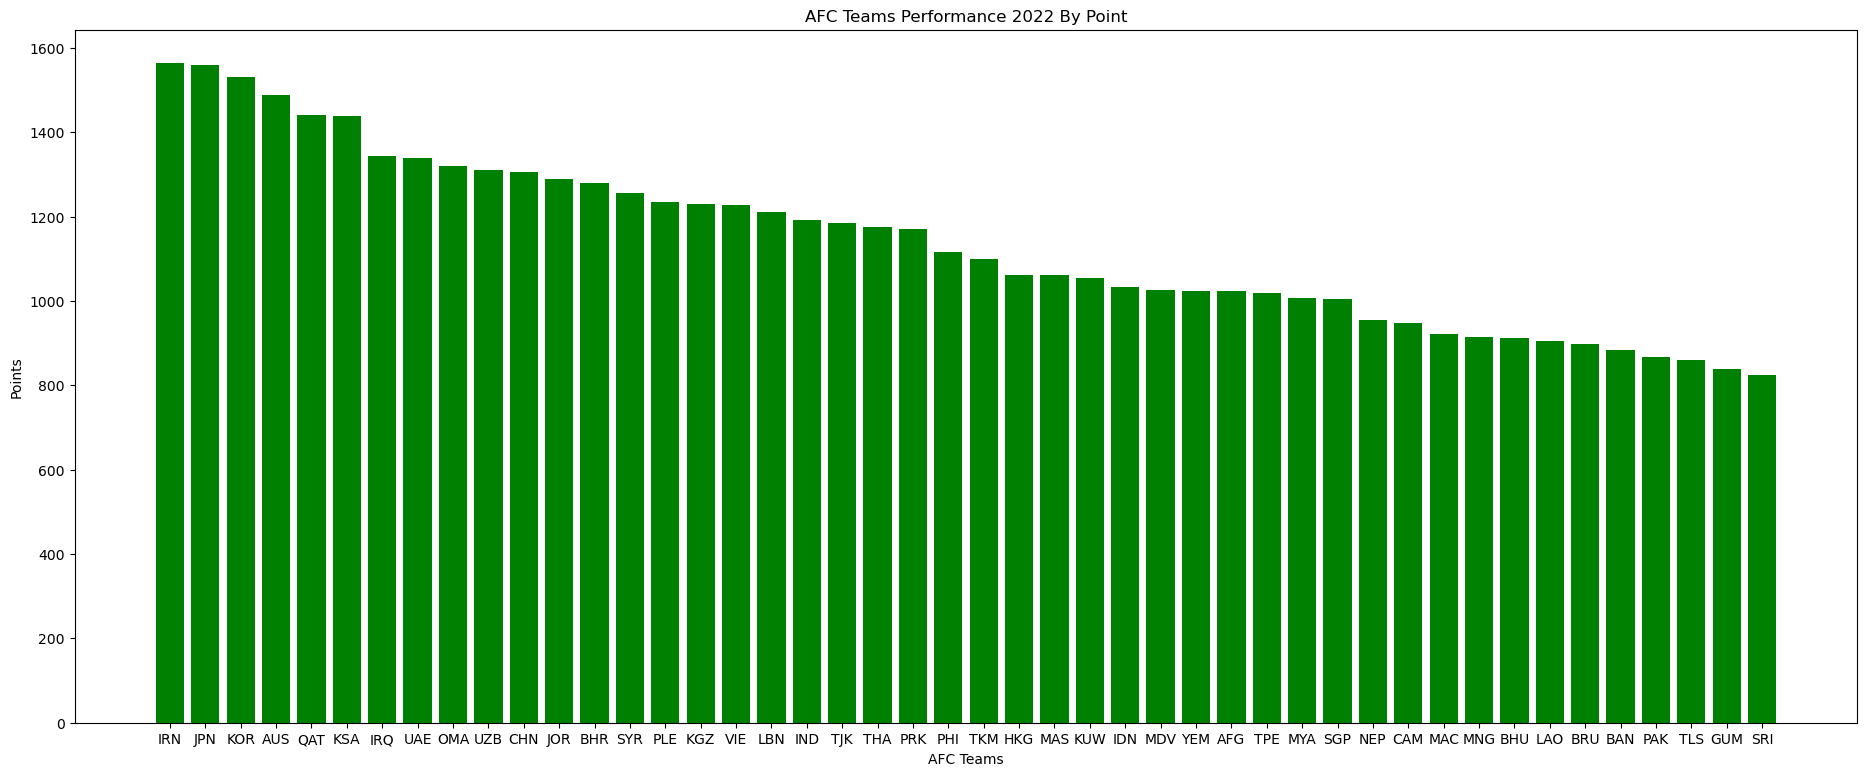

In [62]:
#Plotting AFC association teams performance by point
plt.figure(figsize=(23,9))
plt.bar(df2_asson_per_afc["team_code"], df2_asson_per_afc["points"], color = "green")
plt.xlabel("AFC Teams")
plt.ylabel("Points")
plt.title("AFC Teams Performance 2022 By Point"),
plt.show()

**Interpretation of Result 1**

**From the bar chart above, it can be seen that "Iran" takes the lead in performance by points earned in the
AFC Association**

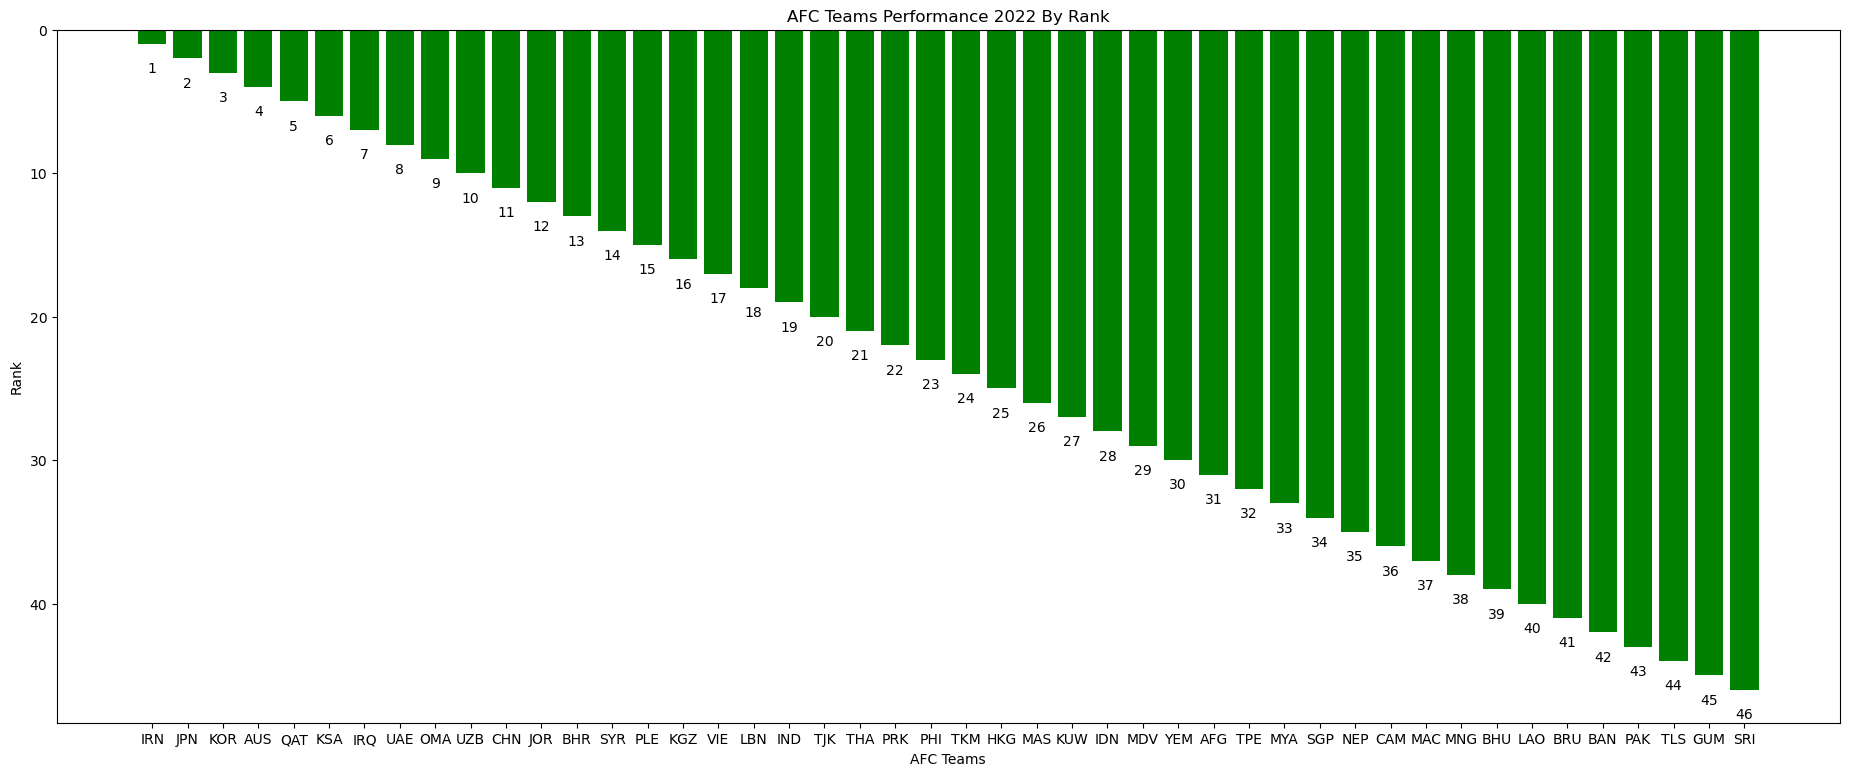

In [63]:
#Plotting AFC association teams performance by rank
plt.figure(figsize=(23,9))
plt.bar(df2_asson_per_afc["team_code"], df2_asson_per_afc["rank"], color = "green")
plt.gca().invert_yaxis()
for i, Rank in enumerate(df2_asson_per_afc["rank"]):
    plt.text(i, Rank +(2), f'{int(Rank)}', ha ="center")
plt.xlabel("AFC Teams")
plt.ylabel("Rank")
plt.title("AFC Teams Performance 2022 By Rank"),
plt.show()

**Interpretation of Result 2**

**Also when it comes to ranking "Iran" also Tops the AFC Association**

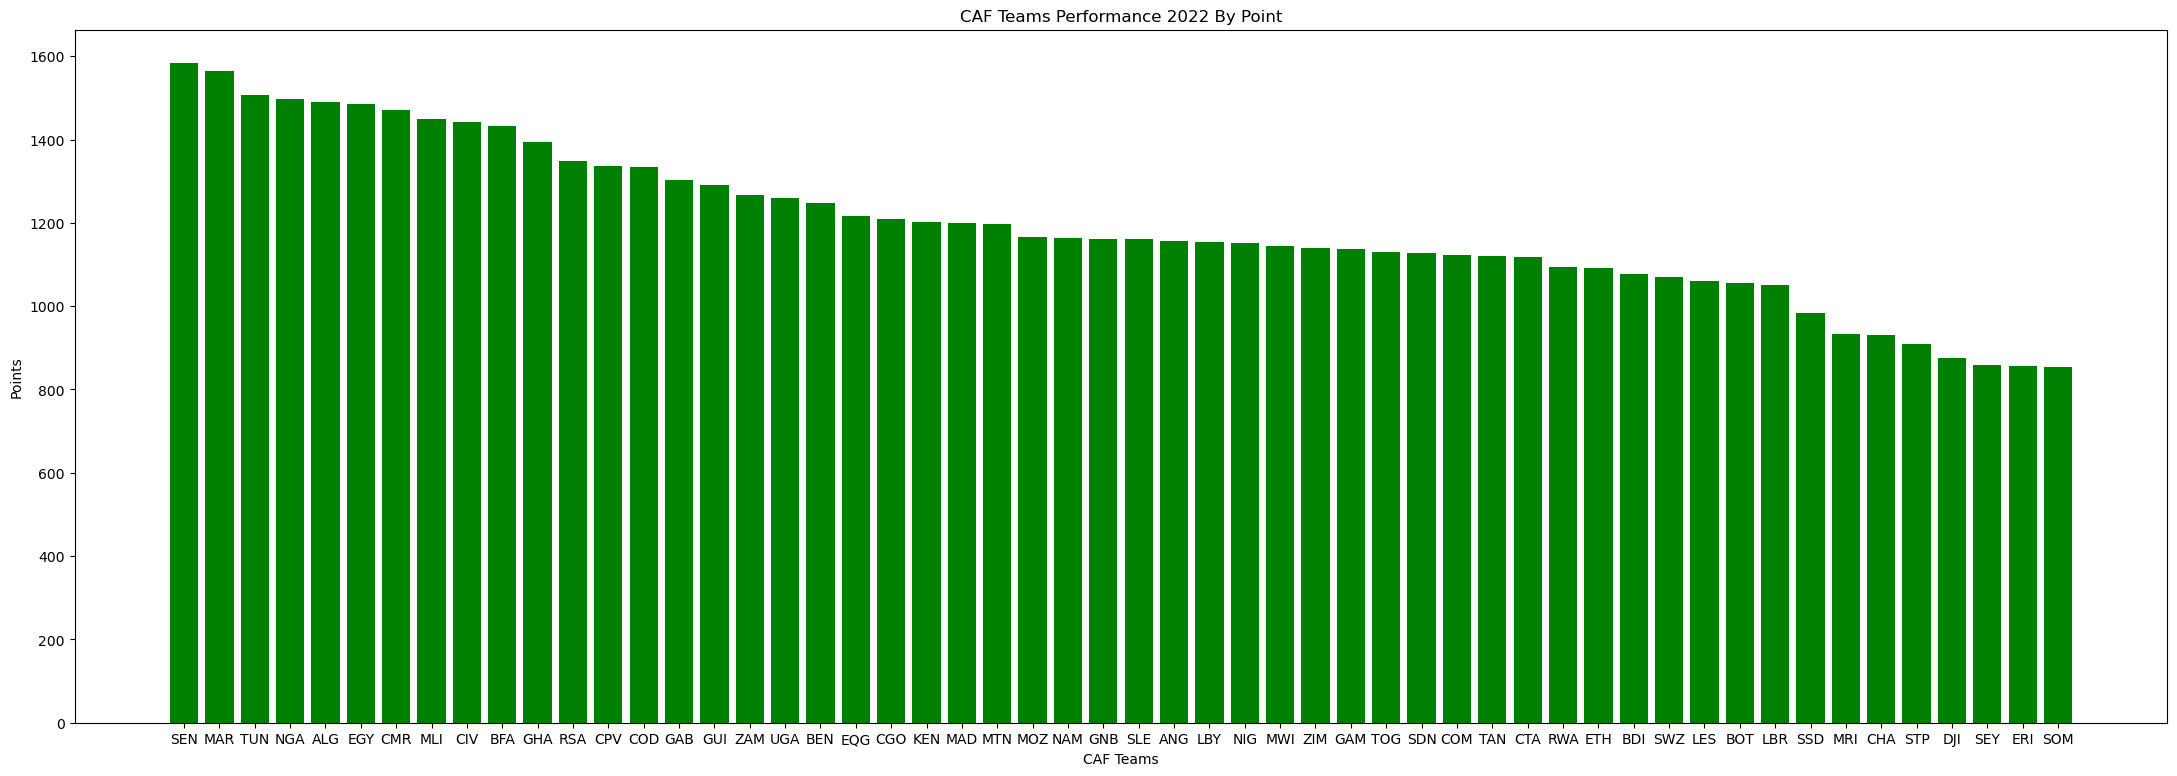

In [64]:
#Plotting CAF association teams performance by points
plt.figure(figsize=(27,9))
plt.bar(df2_asson_per_caf["team_code"], df2_asson_per_caf["points"], color = "green")
plt.xlabel("CAF Teams")
plt.ylabel("Points")
plt.title("CAF Teams Performance 2022 By Point"),
plt.show()

**Interpretation of Result 3**

**From the bar chart above, it can be seen that "Senegal" takes the lead in performance by points earned 
in the CAF Association**

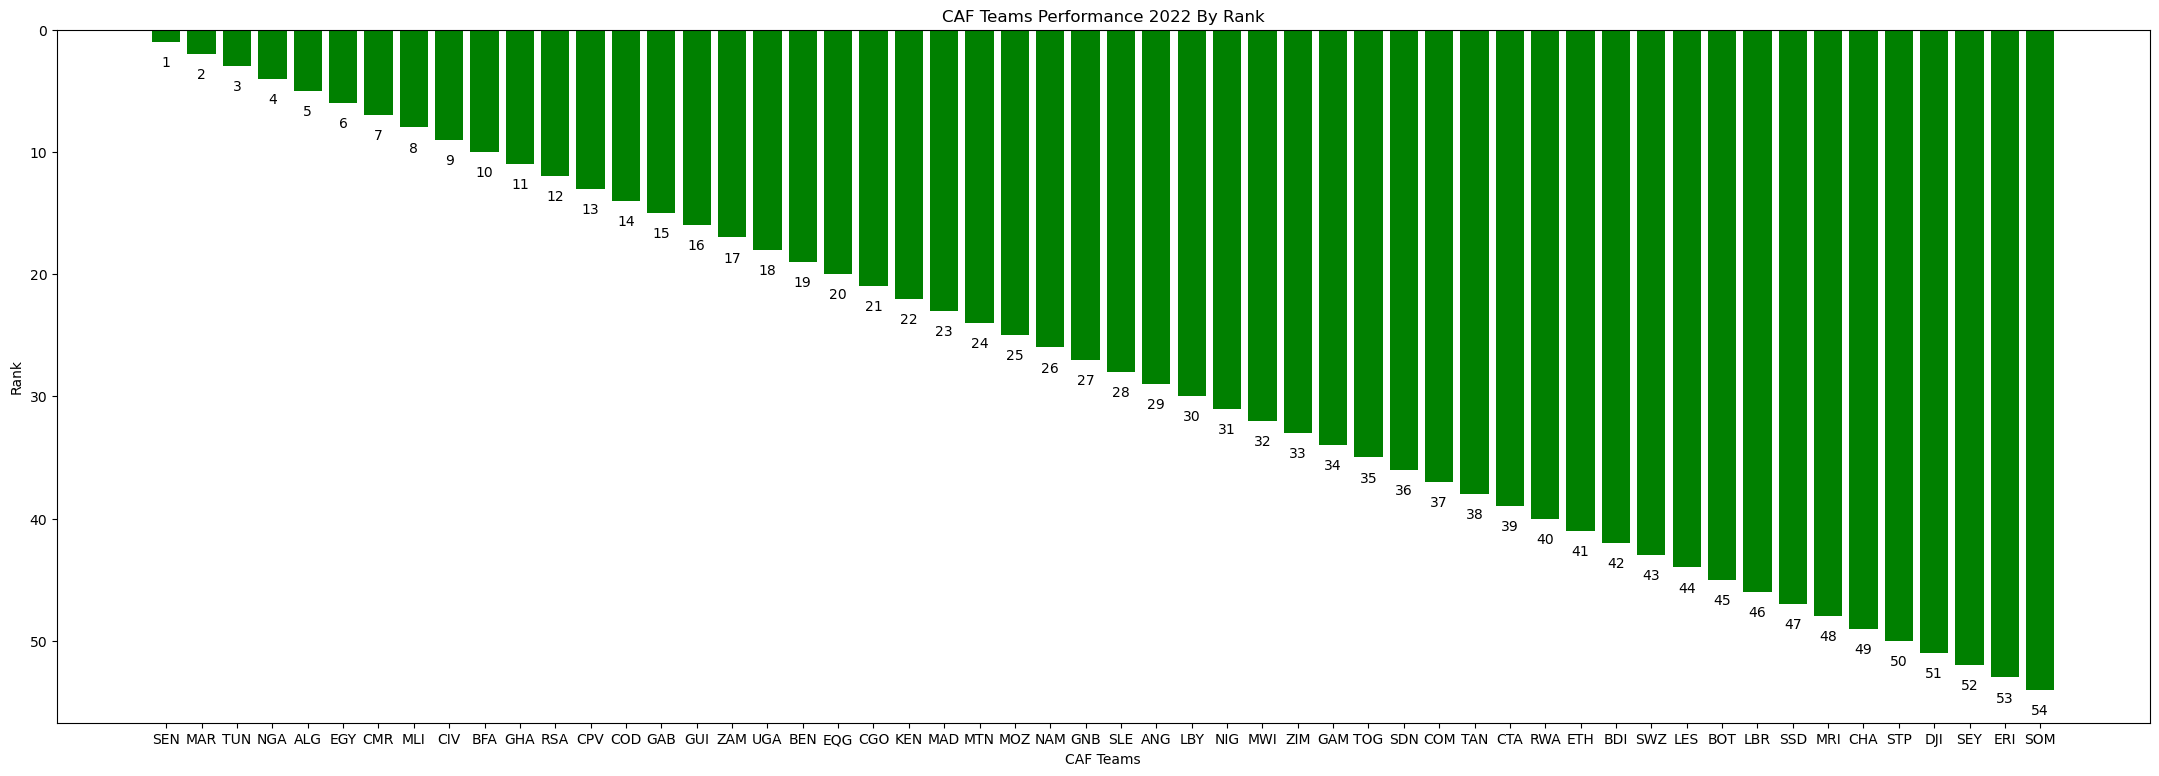

In [65]:
#Plotting CAF association teams performance by rank
plt.figure(figsize=(27,9))
plt.bar(df2_asson_per_caf["team_code"], df2_asson_per_caf["rank"], color = "green")
plt.gca().invert_yaxis()
for i, Rank in enumerate(df2_asson_per_caf["rank"]):
    plt.text(i, Rank +(2), f'{int(Rank)}', ha ="center")
plt.xlabel("CAF Teams")
plt.ylabel("Rank")
plt.title("CAF Teams Performance 2022 By Rank"),
plt.show()

**Interpretation of Result 4**

**Also when it comes to ranking "Senegal" also Tops the CAF Association**

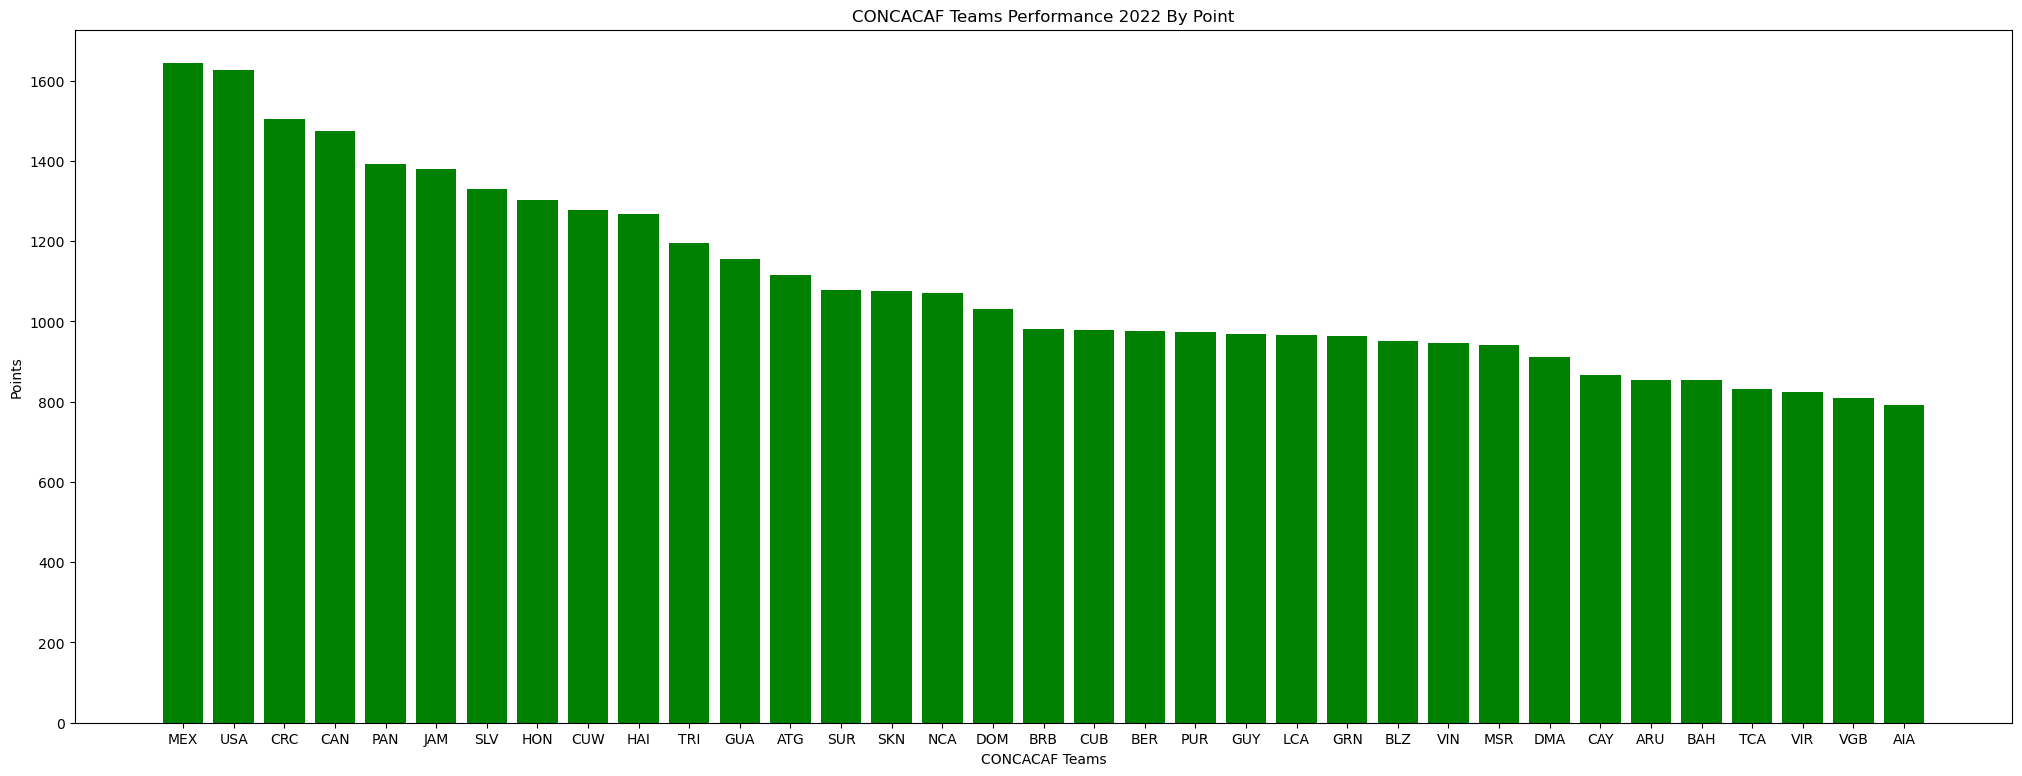

In [66]:
#Plotting CONCACAF association teams performance by points
plt.figure(figsize=(25,9))
plt.bar(df2_asson_per_concacaf["team_code"], df2_asson_per_concacaf["points"], color = "green")
plt.xlabel("CONCACAF Teams")
plt.ylabel("Points")
plt.title("CONCACAF Teams Performance 2022 By Point"),
plt.show()

**Interpretation of Result 5**

**From the bar chart above, it can be seen that "Mexico" takes the lead in performance by points earned
in the CONCACAF Association**

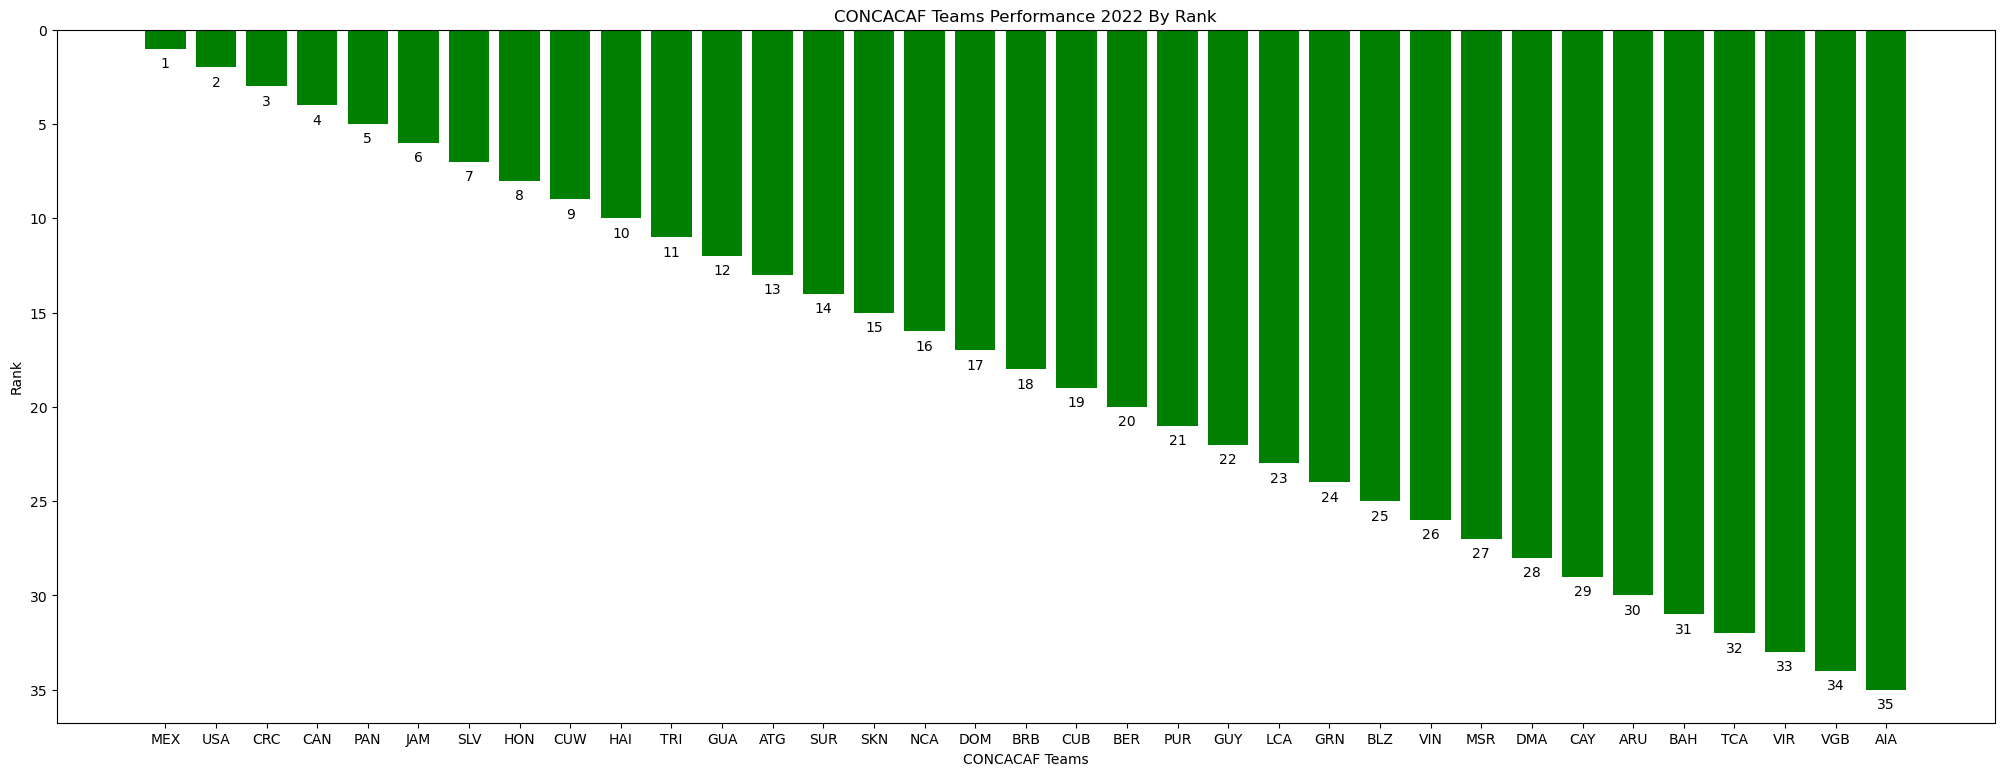

In [67]:
#Plotting CONCACAF association teams performance by rank
plt.figure(figsize=(25,9))
plt.bar(df2_asson_per_concacaf["team_code"], df2_asson_per_concacaf["rank"], color = "green")
plt.gca().invert_yaxis()
for i, Rank in enumerate(df2_asson_per_concacaf["rank"]):
    plt.text(i, Rank +(1), f'{int(Rank)}', ha ="center")
plt.xlabel("CONCACAF Teams")
plt.ylabel("Rank")
plt.title("CONCACAF Teams Performance 2022 By Rank"),
plt.show()

**Interpretation of Result 6**

**Also when it comes to ranking "Mexico" also Tops the CONCACAF Association**

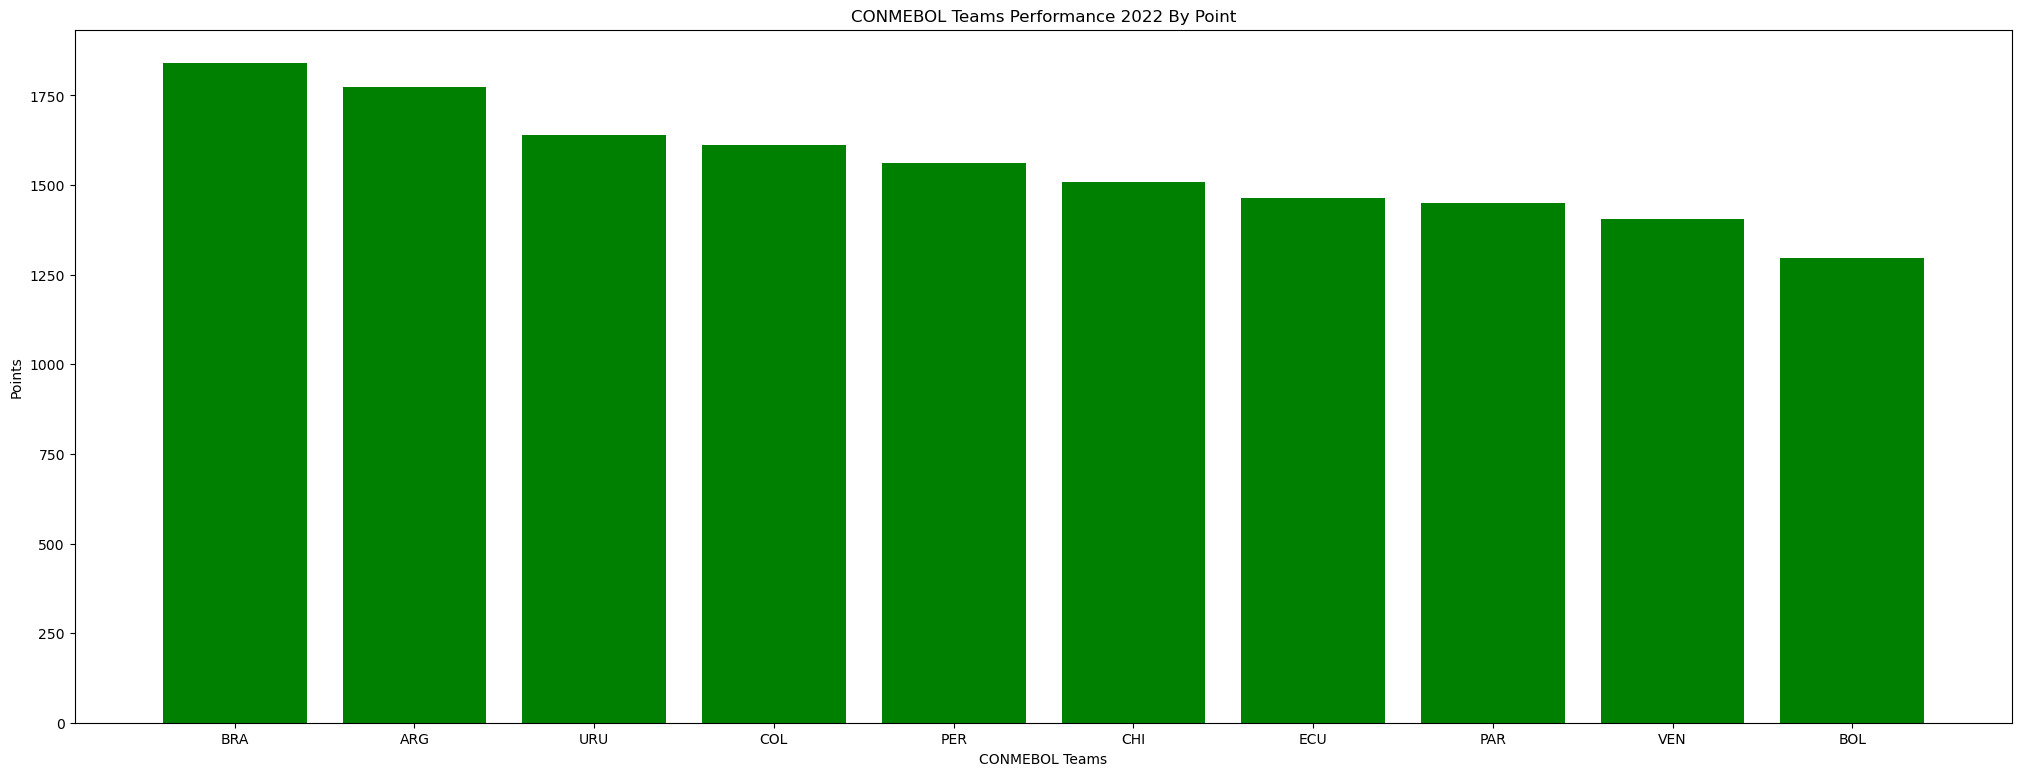

In [68]:
#Plotting CONMEBOL association teams performance by points
plt.figure(figsize=(25,9))
plt.bar(df2_asson_per_conmebol["team_code"], df2_asson_per_conmebol["points"], color = "green")
plt.xlabel("CONMEBOL Teams")
plt.ylabel("Points")
plt.title("CONMEBOL Teams Performance 2022 By Point"),
plt.show()

**Interpretation of Result 7**

**From the bar chart above, it can be seen that "Brazil" takes the lead in performance by points earned
in the CONMEBOL Association**

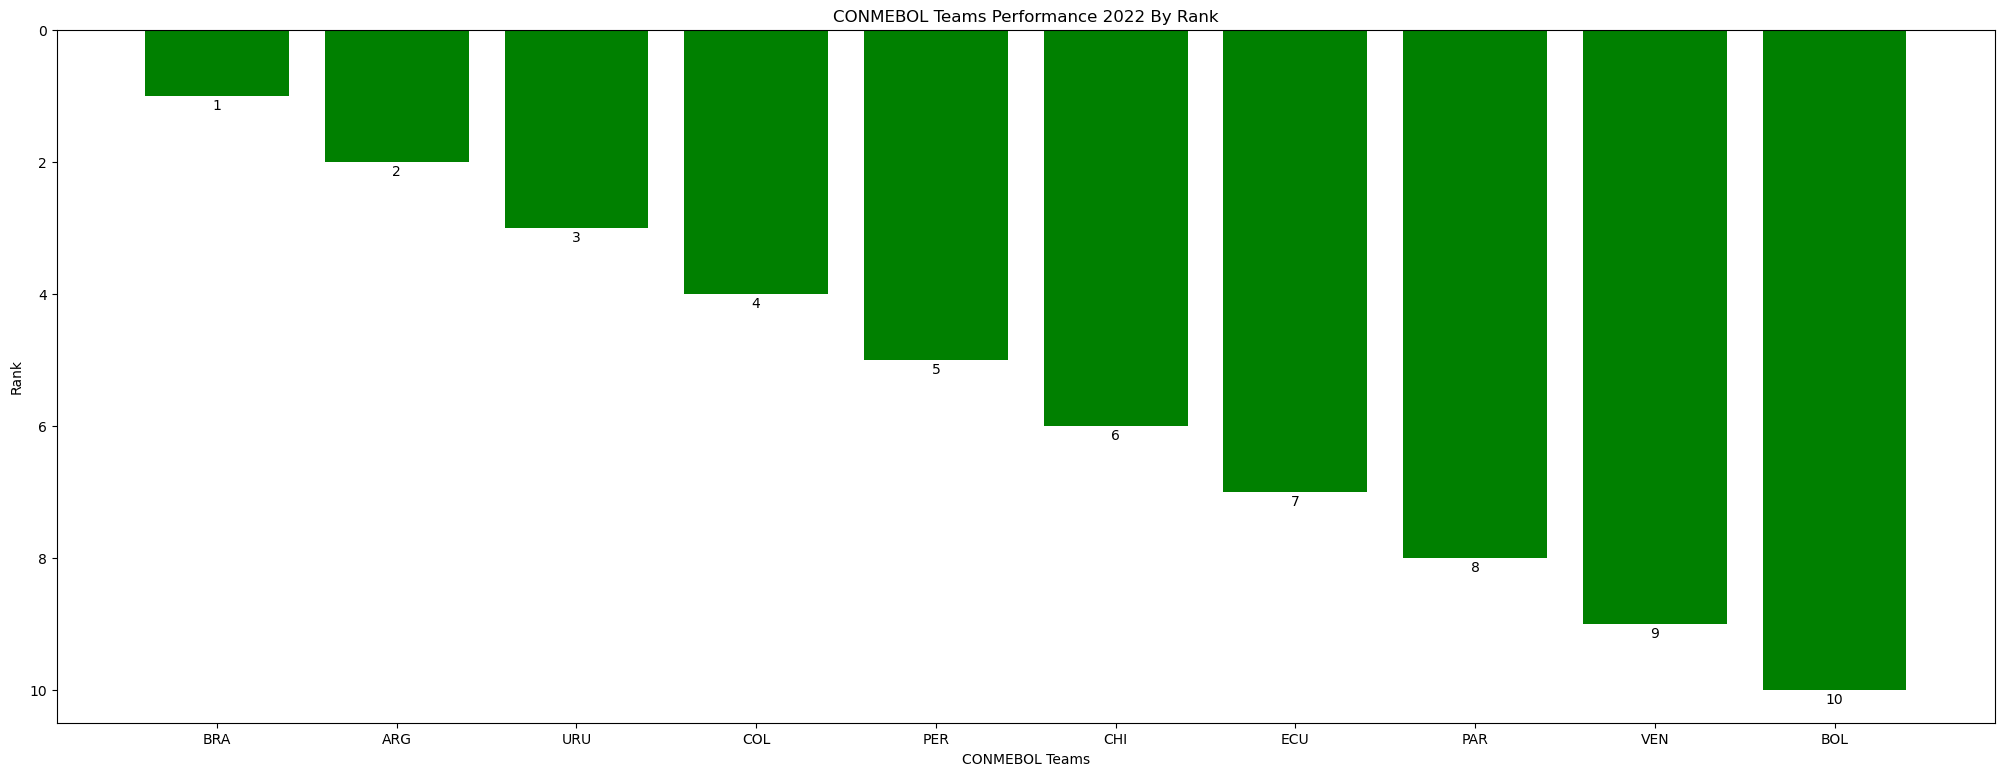

In [69]:
#Plotting CONMEBOL association teams performance by rank
plt.figure(figsize=(25,9))
plt.bar(df2_asson_per_conmebol["team_code"], df2_asson_per_conmebol["rank"], color = "green")
plt.gca().invert_yaxis()
for i, Rank in enumerate(df2_asson_per_conmebol["rank"]):
    plt.text(i, Rank +(0.2), f'{int(Rank)}', ha ="center")
plt.xlabel("CONMEBOL Teams")
plt.ylabel("Rank")
plt.title("CONMEBOL Teams Performance 2022 By Rank"),
plt.show()

**Interpretation of Result 8**

**Also when it comes to ranking "Brazil" also Tops the CONMEBOL Association**

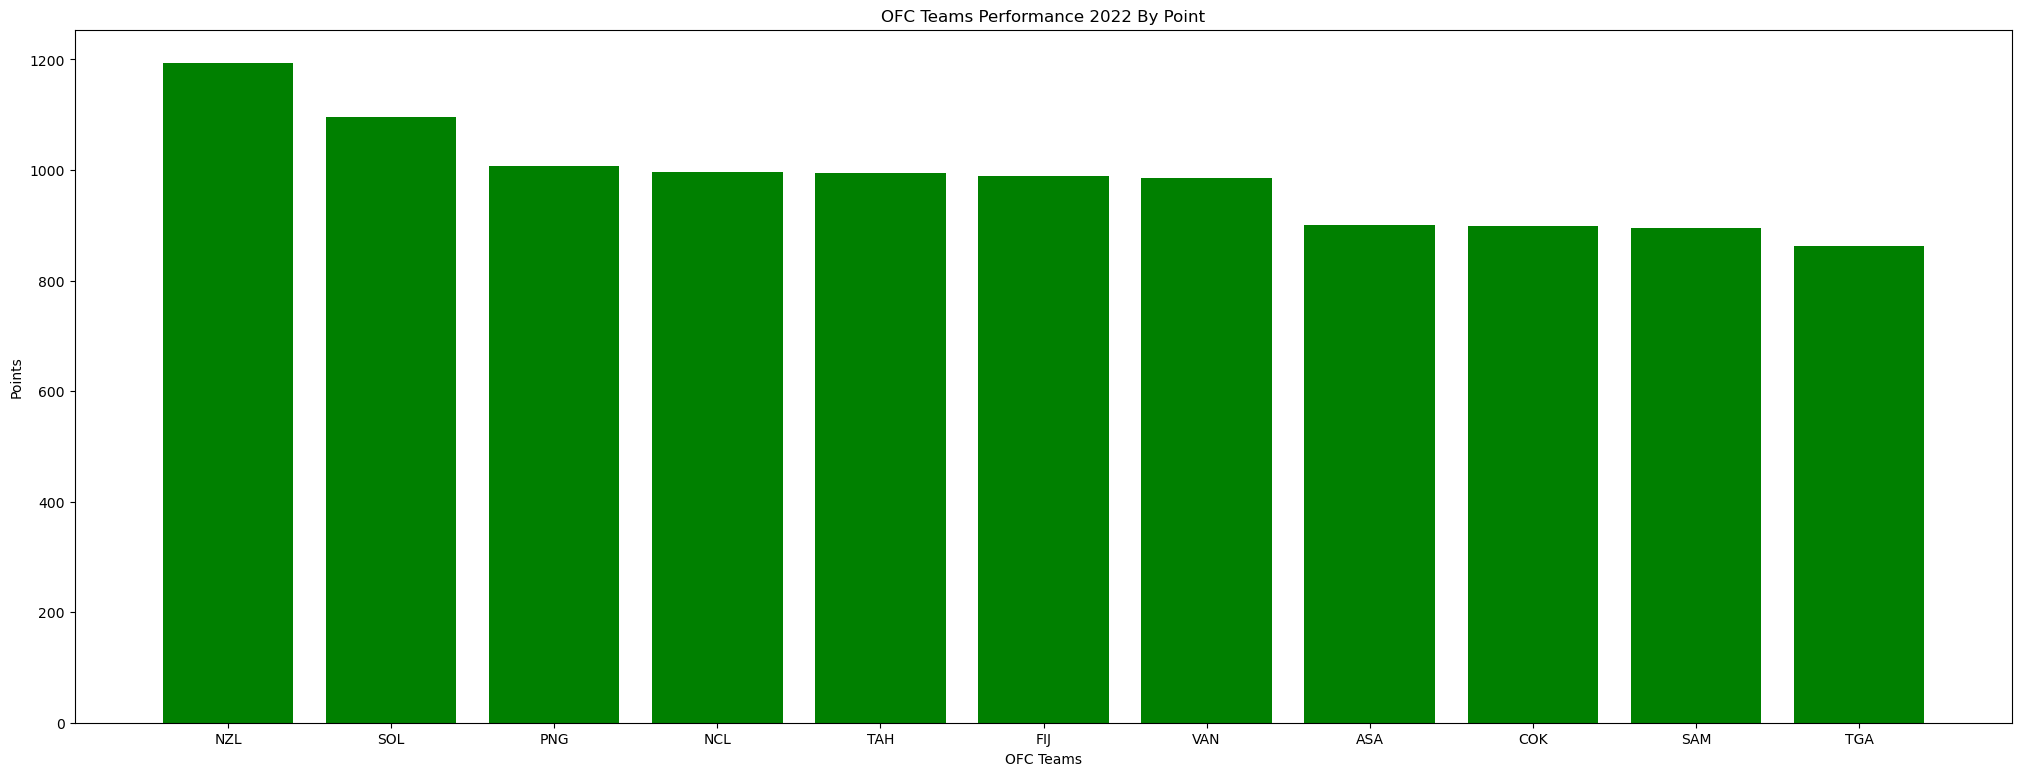

In [70]:
#Plotting OFC association teams performance by points
plt.figure(figsize=(25,9))
plt.bar(df2_asson_per_ofc["team_code"], df2_asson_per_ofc["points"], color = "green")
plt.xlabel("OFC Teams")
plt.ylabel("Points")
plt.title("OFC Teams Performance 2022 By Point"),
plt.show()

**Interpretation of Result 9**

**From the bar chart above, it can be seen that "New Zealand" takes the lead in performance by points earned
in the OFC Association**

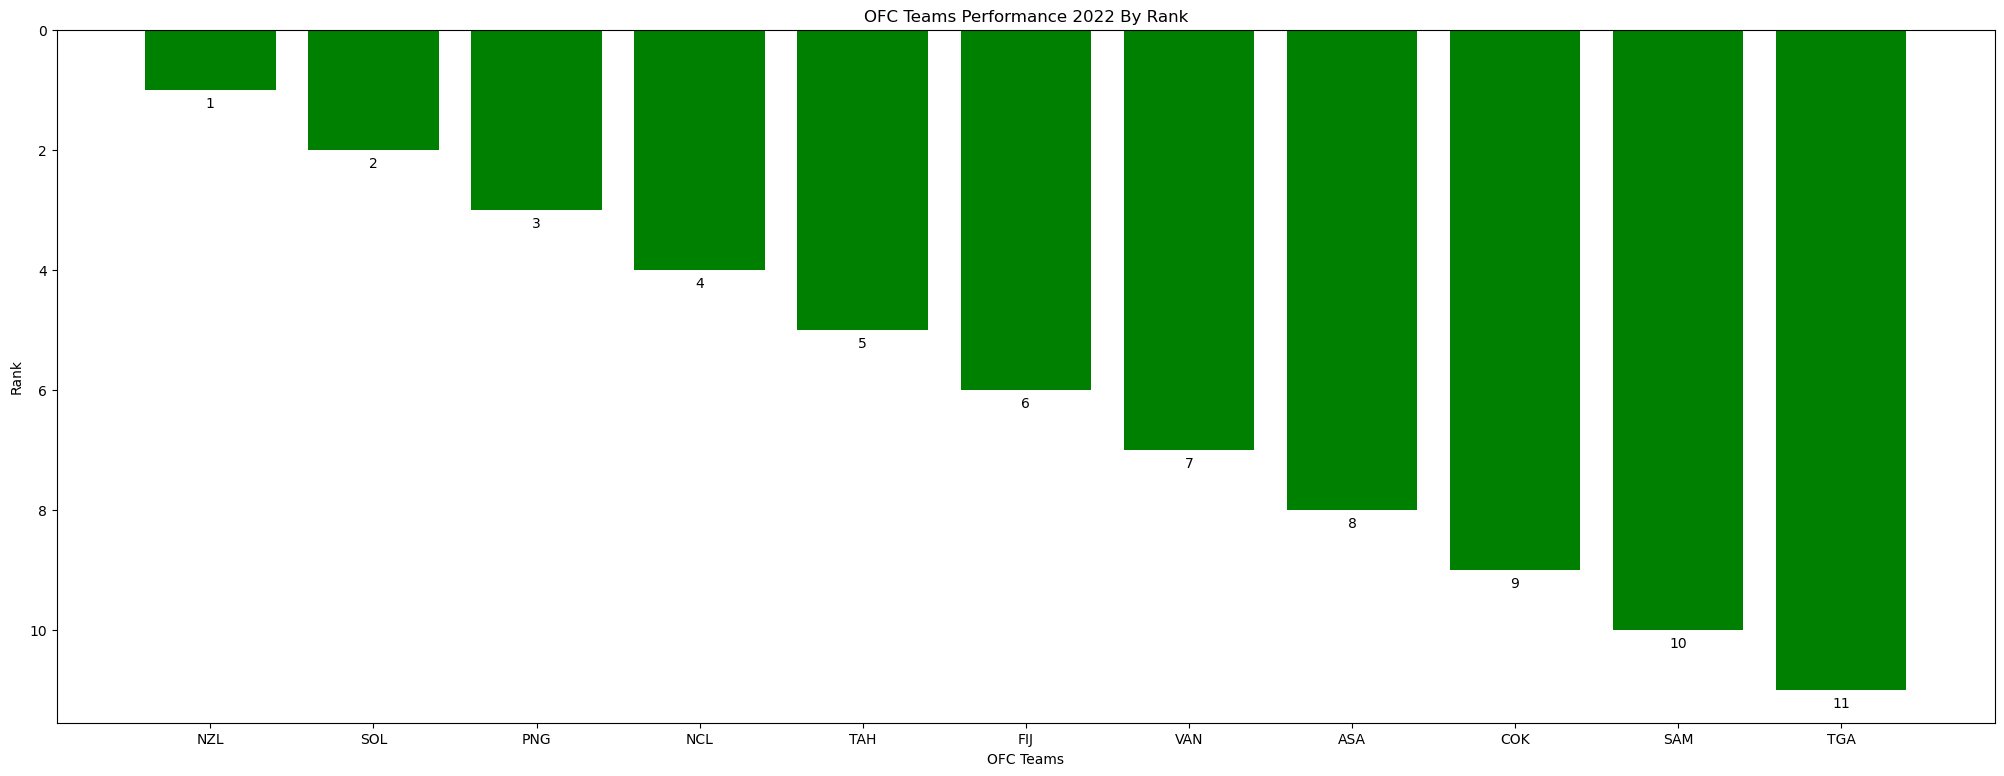

In [71]:
#Plotting OFC association teams performance by rank
plt.figure(figsize=(25,9))
plt.bar(df2_asson_per_ofc["team_code"], df2_asson_per_ofc["rank"], color = "green")
plt.gca().invert_yaxis()
for i, Rank in enumerate(df2_asson_per_ofc["rank"]):
    plt.text(i, Rank +(0.3), f'{int(Rank)}', ha ="center")
plt.xlabel("OFC Teams")
plt.ylabel("Rank")
plt.title("OFC Teams Performance 2022 By Rank"),
plt.show()

**Interpretation of Result 10**

**Also when it comes to ranking "New Zealand" also Tops the OFC Association**

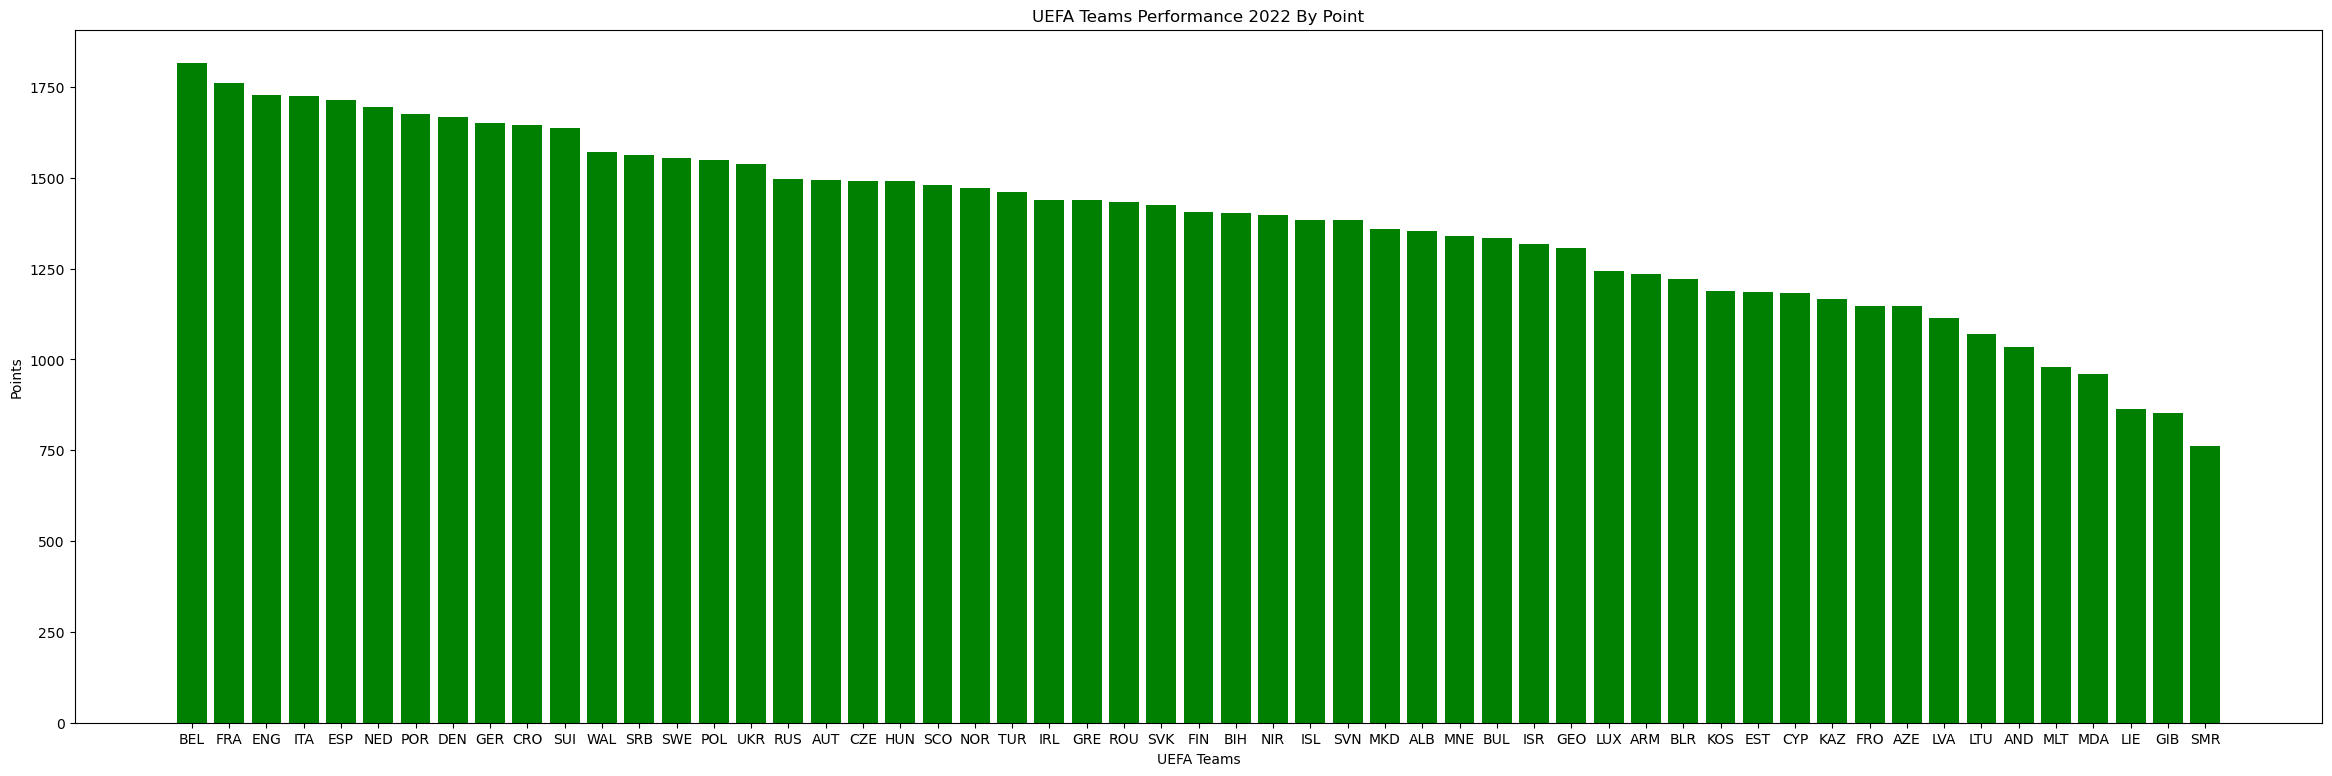

In [72]:
#Plotting UEFA association teams performance by points
plt.figure(figsize=(29,9))
plt.bar(df2_asson_per_uefa["team_code"], df2_asson_per_uefa["points"], color = "green")
plt.xlabel("UEFA Teams")
plt.ylabel("Points")
plt.title("UEFA Teams Performance 2022 By Point"),
plt.show()

**Interpretation of Result 11**

**From the bar chart above, it can be seen that "Belgium" takes the lead in performance by points earned
in the UEFA Association**

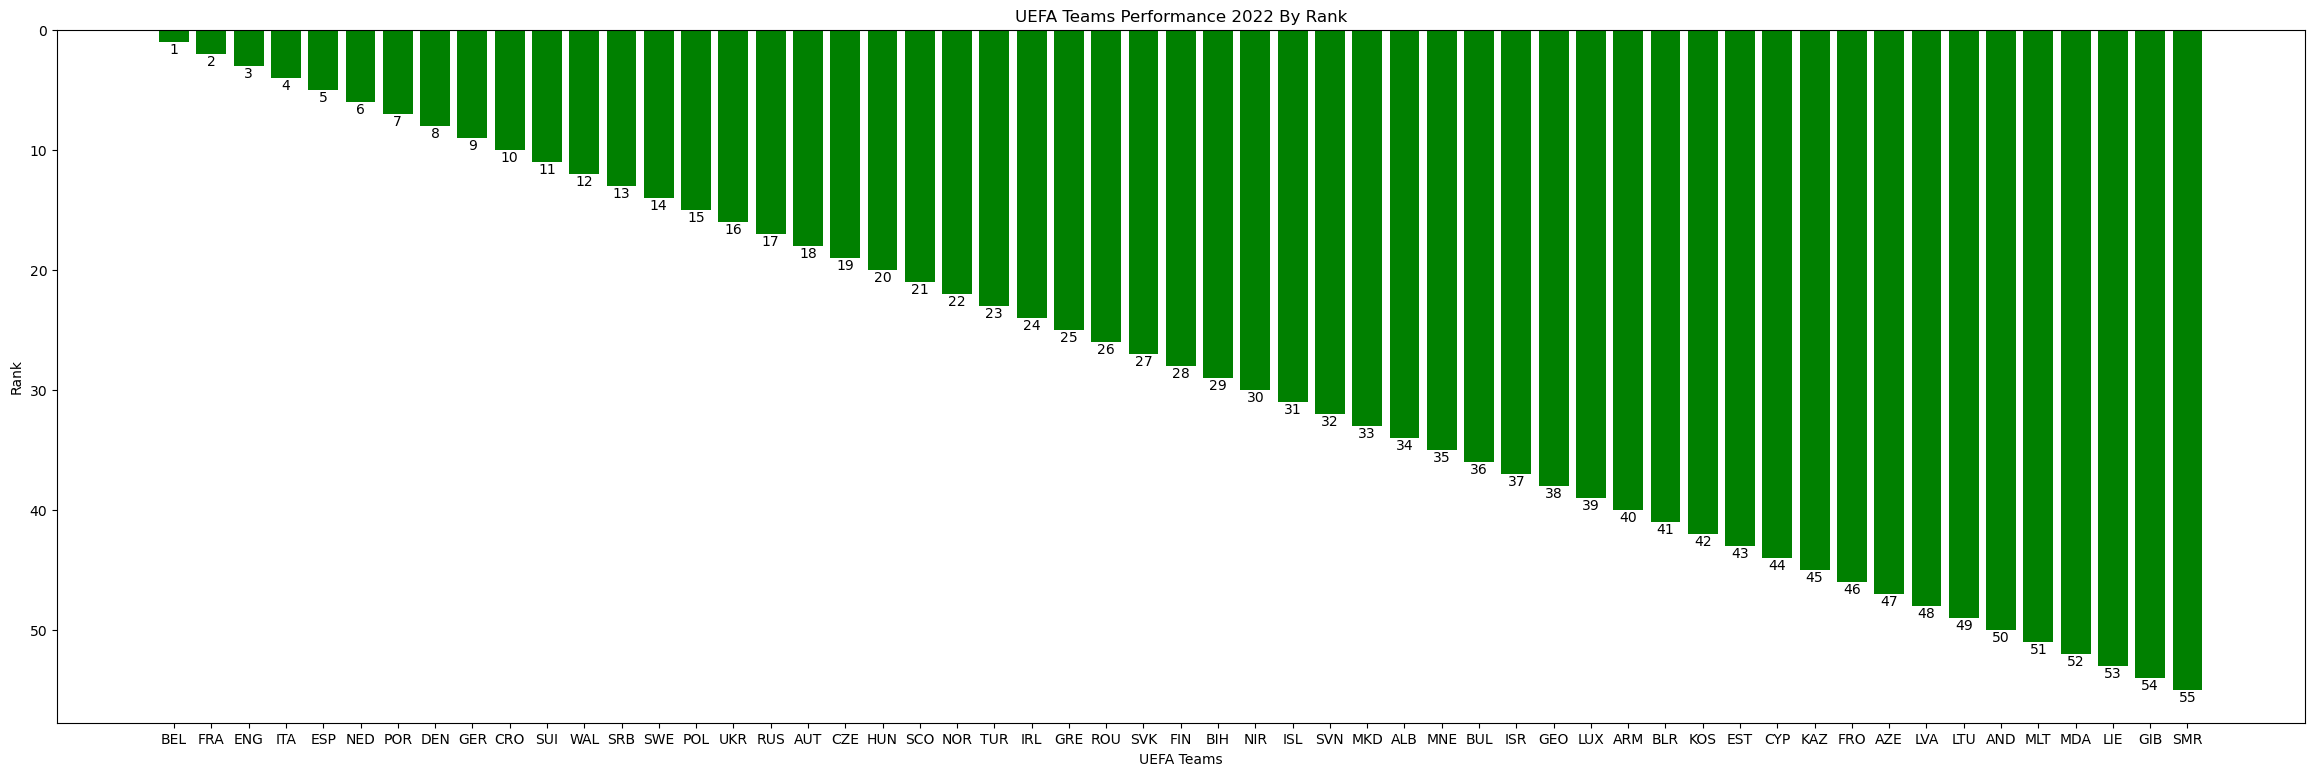

In [73]:
#Plotting UEFA association teams performance by rank
plt.figure(figsize=(29,9))
plt.bar(df2_asson_per_uefa["team_code"], df2_asson_per_uefa["rank"], color = "green")
plt.gca().invert_yaxis()
for i, Rank in enumerate(df2_asson_per_uefa["rank"]):
    plt.text(i, Rank +(1), f'{int(Rank)}', ha ="center")
plt.xlabel("UEFA Teams")
plt.ylabel("Rank")
plt.title("UEFA Teams Performance 2022 By Rank"),
plt.show()

**Interpretation of Result 12**

**Also when it comes to ranking "Belgium" also Tops the OFC Association**

**Objective 7**

**To analyze the attendance number across different world cup years to see if there's a trend in spectator interest**

In [74]:
df3.head()

,Year,Host,Teams,Champion,Runner-Up,TopScorrer,Attendance,AttendanceAvg,Matches
0,2022,Qatar,32,Argentina,France,Kylian Mbappé - 8,3404252,53191,64
1,2018,Russia,32,France,Croatia,Harry Kane - 6,3031768,47371,64
2,2014,Brazil,32,Germany,Argentina,James Rodríguez - 6,3429873,53592,64
3,2010,South Africa,32,Spain,Netherlands,"Wesley Sneijder, Thomas Müller... - 5",3178856,49670,64
4,2006,Germany,32,Italy,France,Miroslav Klose - 5,3352605,52384,64


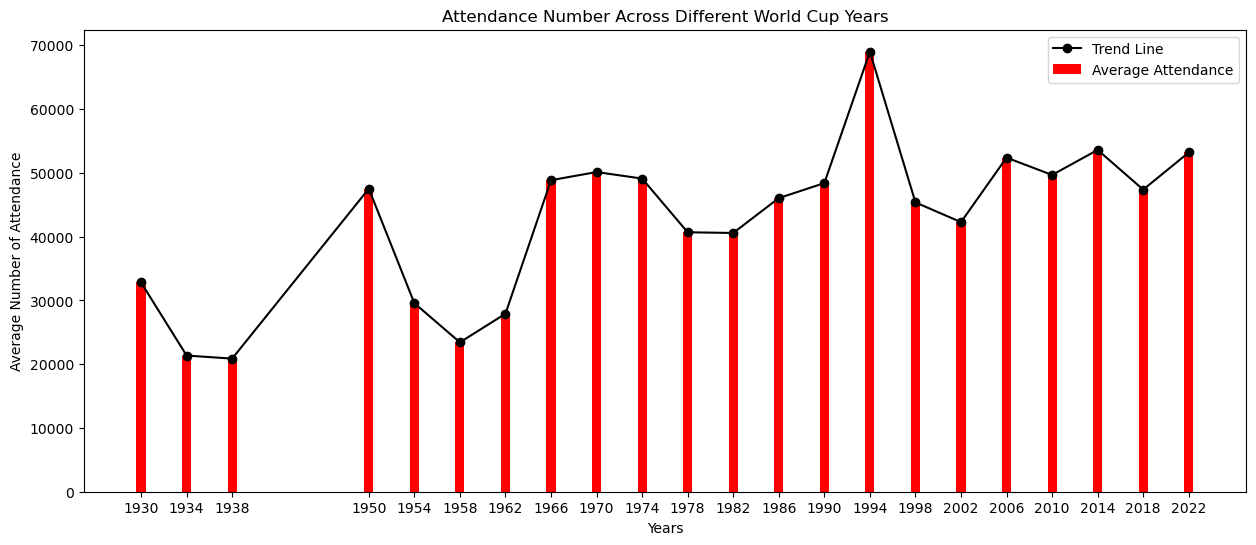

In [75]:
plt.figure(figsize = (15, 6))
#Creating a bar plot
plt.bar(df3["Year"], df3["AttendanceAvg"], color = "red", label = "Average Attendance")
#Plotting a line to connect all points
plt.plot(df3["Year"], df3["AttendanceAvg"], color = "black", label = "Trend Line", marker = "o")
#Setting custom y-ticks to show only unique years
plt.xticks(df3["Year"])
#Adding labels and ledgend
plt.xlabel("Years")
plt.ylabel("Average Number of Attendance")
plt.title("Attendance Number Across Different World Cup Years")
plt.legend();


**Interpretation of Result**

**From the plot above, it can be seen that there is fluctuation over the years which reflect
varying level of spectator interest in each world cup. judging by the trend line, we can conclude that
spectator interest in the world cup has remained strong and stable over time with some years exhibiting
particularly high level of engagement. This pattern suggest that the world cup continues to be a highly
anticipated event worldwide.**

**Objective 8**

**To determine the all time Top scorer in a single world cup and if there's a pattern in the number of goals 
scored in each world cup.**

In [76]:
df3.head(2)

,Year,Host,Teams,Champion,Runner-Up,TopScorrer,Attendance,AttendanceAvg,Matches
0,2022,Qatar,32,Argentina,France,Kylian Mbappé - 8,3404252,53191,64
1,2018,Russia,32,France,Croatia,Harry Kane - 6,3031768,47371,64


In [77]:
#Splitting TopScorrer column
df3[["TopScorrer_Name", "TopScorrer_Goal"]] = df3["TopScorrer"].str.split("-", expand = True)
df3 = df3.sort_values(by = "Year", ascending = True)
df3["TopScorrer_Goal"] = df3["TopScorrer_Goal"].astype("int64")

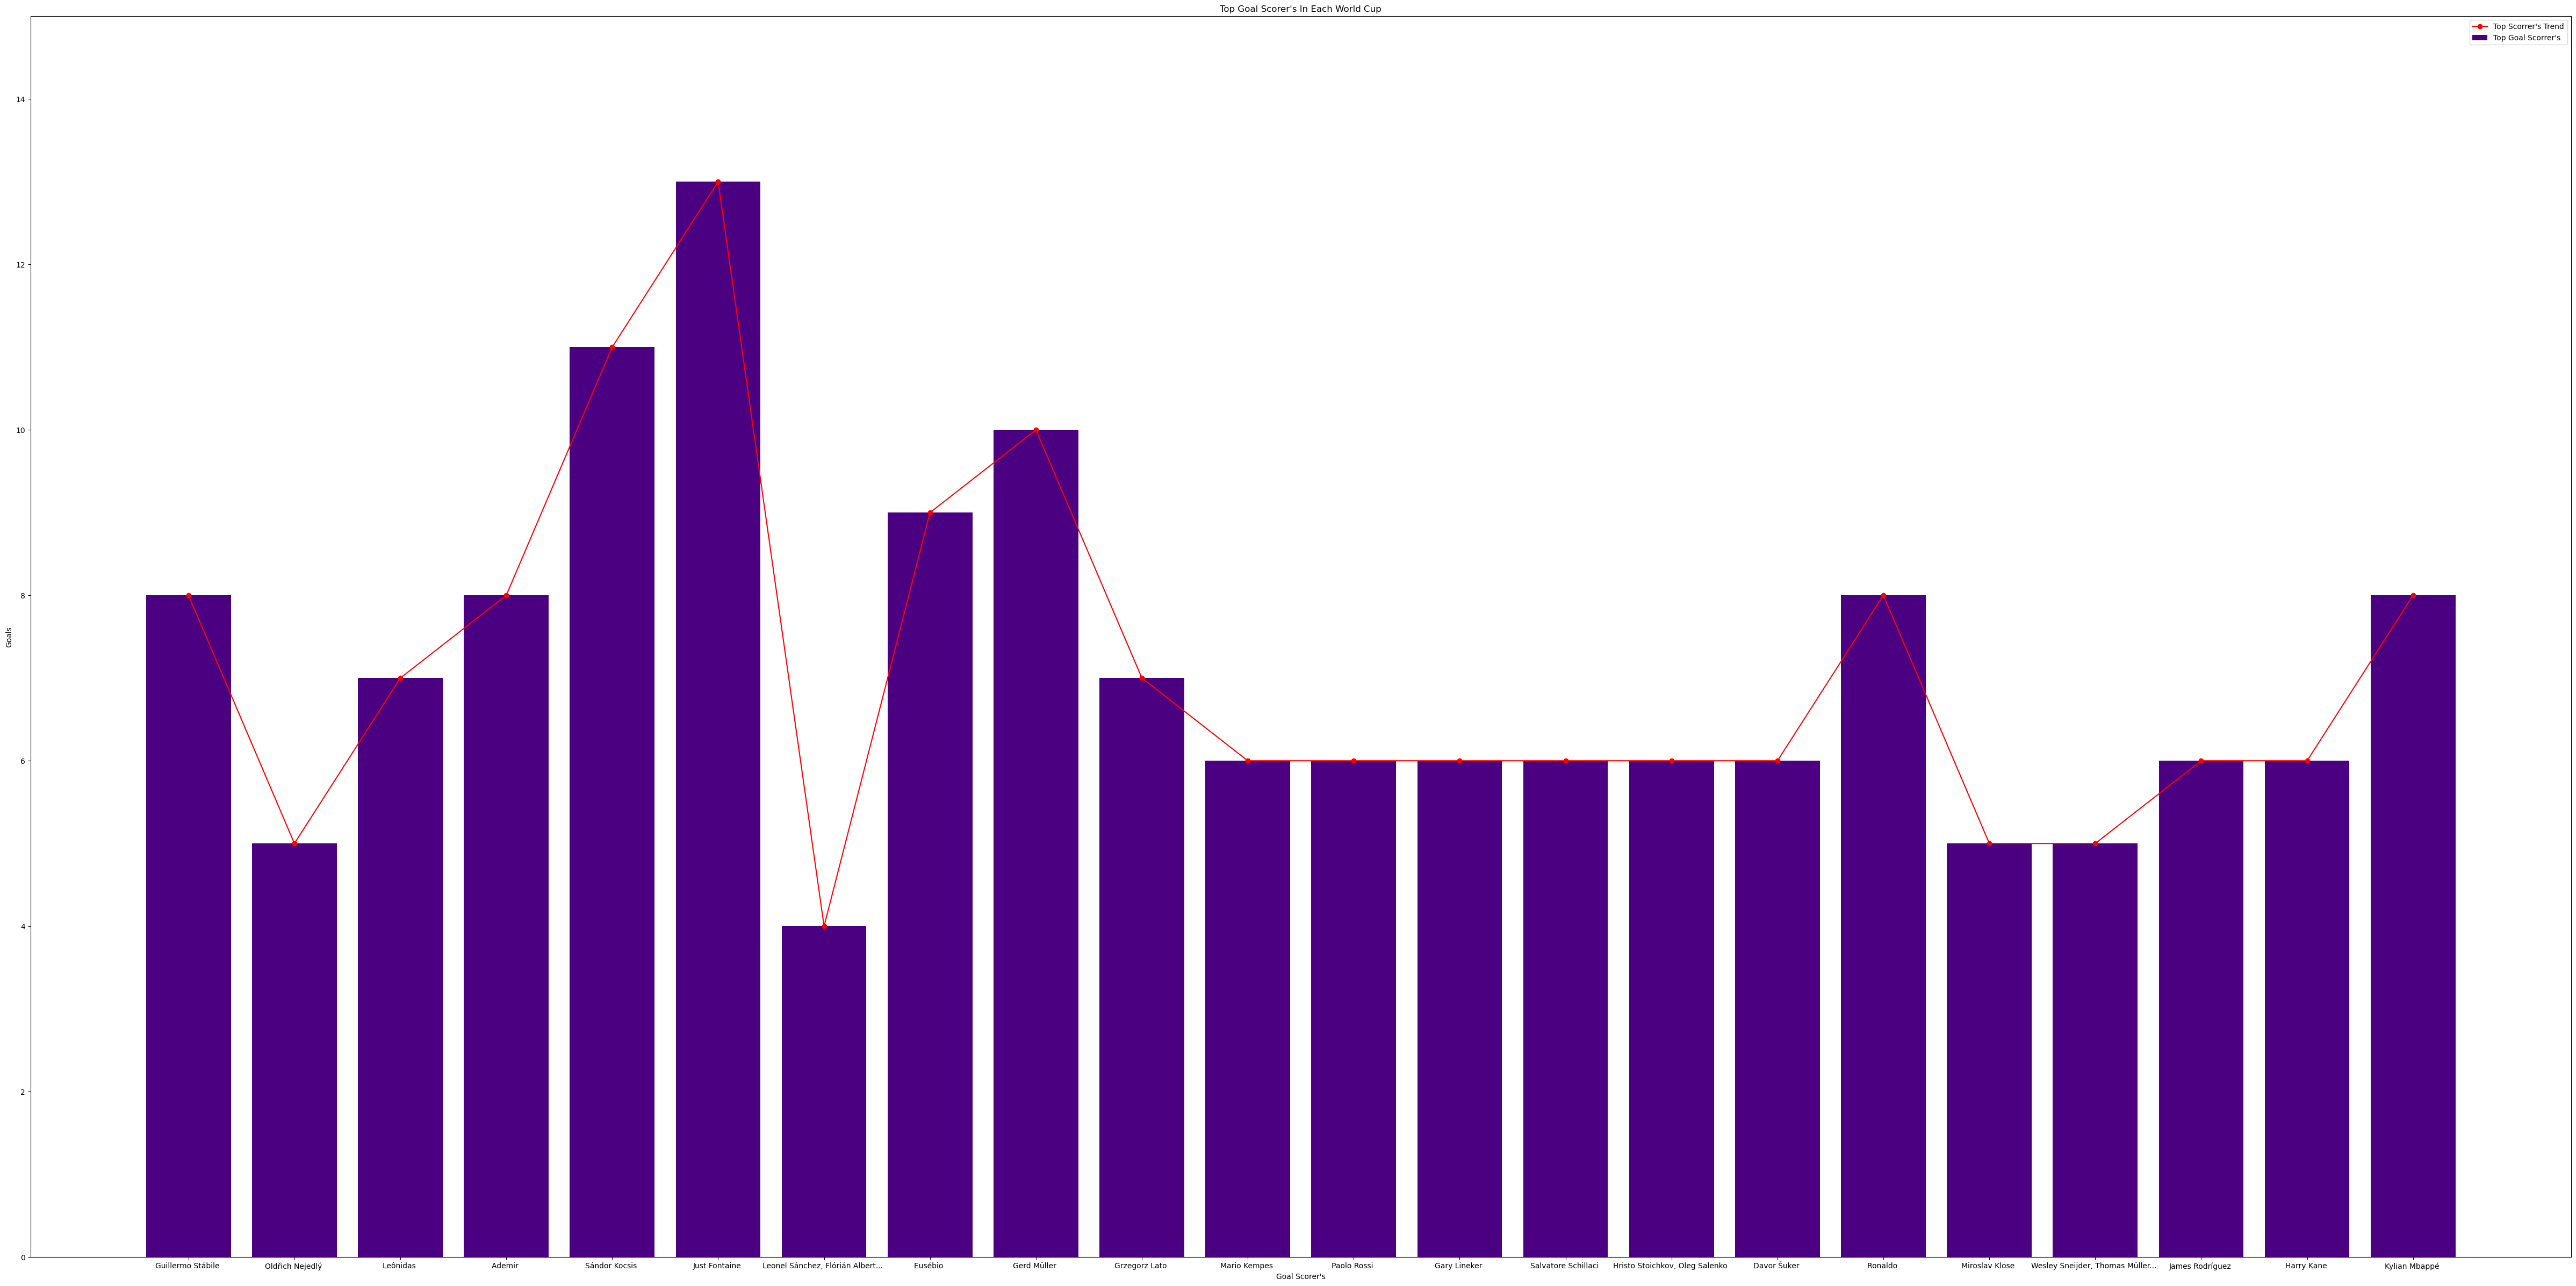

In [78]:
plt.figure(figsize = (61, 30))
#Creating a bar plot
plt.bar(df3["TopScorrer_Name"], df3["TopScorrer_Goal"], color = "indigo", label = "Top Goal Scorrer's")
#Plotting a line to connect all points
plt.plot(df3["TopScorrer_Name"], df3["TopScorrer_Goal"], color = "red", label = "Top Scorrer's Trend", marker = "o")
#Setting y-axis limits
plt.ylim(0, max(df3["TopScorrer_Goal"]+ 2))
#Adding labels and ledgend
plt.xlabel("Goal Scorer's")
plt.ylabel("Goals")
plt.title("Top Goal Scorer's In Each World Cup")
plt.legend();


**Interpretation of Result**

**From the bar chart above there appear not to be a simple, linear pattern (increase or decrease over time). when it
comes to the Top scorer all in a single world cup "Just Fontaine" takes the lead with 13 goals**